# Solar Generation Forecast

- Energy Traders making bets on renewable generation and its contribution to meeting energy demand.
- Day Ahead Planners in utilities preparing for or short-term planning horizons
- Calculating vital metrics such as Net Demand. I
- Initializing Power Flow simulation models

## Librairies

In [55]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import pvlib
import urllib
import requests
import geocoder
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from pvlib import location as pvlib_location
from datetime import timedelta
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from plotly.subplots import make_subplots
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt
import optuna
import plotly.express as px
import plotly.graph_objects as go
import random
import seaborn as sns
import statsmodels.api as sm
import time
import xgboost as xgb

import pvlib
from pvlib.location import Location
from pvlib import clearsky

import time
import datetime
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import norm

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


## Dataset

In [56]:
# Specify the file path of the Excel file
file_path = 'CAISO Total Solar Historical Actuals.xlsx'

# Specify the sheet name
sheet_name = 'CAISO Total System Solar Power '

# Read the specified range in the specified sheet
df1= pd.read_excel(file_path, sheet_name=sheet_name, header=2)
# df['Date'] = pd.to_datetime(df['Date'])

# Print the DataFrame
print(df1)

            Date  Hour  Actual
0     2020-05-16     1       0
1     2020-05-16     2       0
2     2020-05-16     3       0
3     2020-05-16     4       0
4     2020-05-16     5       0
...          ...   ...     ...
26188 2023-05-14    20     874
26189 2023-05-14    21       0
26190 2023-05-14    22       3
26191 2023-05-14    23       7
26192 2023-05-14    24       6

[26193 rows x 3 columns]


## Explanatory Data Analysis

In [57]:
# Find duplicate records
duplicates = df1.duplicated()
# Print the number of duplicate records
print('Number of duplicate records:', duplicates.sum())

Number of duplicate records: 5


In [58]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    26193 non-null  datetime64[ns]
 1   Hour    26193 non-null  int64         
 2   Actual  26193 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 614.0 KB


In [59]:
df1.isnull().sum()

Date      0
Hour      0
Actual    0
dtype: int64

In [60]:
# Combine the 'Date' and 'Hour' columns into a new column
df1['DateTime'] = pd.to_datetime(df1['Date']) + pd.to_timedelta(df1['Hour'], unit='h')

# This line adjust the date at midnight hours to be consistent with date in the "Actuals data"
#df1.loc[df1['DateTime'].apply(lambda x:x.hour)==0, 'DateTime'] = df1.loc[df1['DateTime'].apply(lambda x:x.hour)==0, 'DateTime'].apply(lambda x:x-timedelta(days=1))

print(df1.head())

# Create a line plot using Plotly
fig = px.line(df1, x='DateTime', y='Actual')

# Set the title and labels
fig.update_layout(title='Actual Values by Hour',
                  xaxis_title='Date and Hour',
                  yaxis_title='Actual Values')

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Display the plot
fig.show()

        Date  Hour  Actual            DateTime
0 2020-05-16     1       0 2020-05-16 01:00:00
1 2020-05-16     2       0 2020-05-16 02:00:00
2 2020-05-16     3       0 2020-05-16 03:00:00
3 2020-05-16     4       0 2020-05-16 04:00:00
4 2020-05-16     5       0 2020-05-16 05:00:00


In [61]:
# Create the line plot
fig = px.line(df1, x='Hour', y='Actual', color='Date', title='Actual Values by Hour')

# Set the axis labels
fig.update_layout(xaxis_title='Hour', yaxis_title='Actual')

# Show the plot
fig.show()

In [62]:
# Reorder the columns
df1 = df1.reindex(columns=['DateTime', 'Date', 'Hour', 'Actual'])

# Print the updated DataFrame
print(df1)

                 DateTime       Date  Hour  Actual
0     2020-05-16 01:00:00 2020-05-16     1       0
1     2020-05-16 02:00:00 2020-05-16     2       0
2     2020-05-16 03:00:00 2020-05-16     3       0
3     2020-05-16 04:00:00 2020-05-16     4       0
4     2020-05-16 05:00:00 2020-05-16     5       0
...                   ...        ...   ...     ...
26188 2023-05-14 20:00:00 2023-05-14    20     874
26189 2023-05-14 21:00:00 2023-05-14    21       0
26190 2023-05-14 22:00:00 2023-05-14    22       3
26191 2023-05-14 23:00:00 2023-05-14    23       7
26192 2023-05-15 00:00:00 2023-05-14    24       6

[26193 rows x 4 columns]


## Retrieve Carlifornia region info

In [63]:
# Function to retrieve altitude (elevation) based on latitude and longitude
def get_altitude(latitude, longitude):
    geolocator = Nominatim(user_agent='my-app')
    location = geolocator.reverse(f'{latitude}, {longitude}', exactly_one=True)
    if location.raw.get('elevation'):
        return location.raw['elevation']
    else:
        return None

# Specify the regions
regions = ['Northern California', 'Central California', 'Southern California']
# regions = 'California' #different results


# Create a geocoder instance
geolocator = Nominatim(user_agent='my-app')

# Initialize empty lists for latitude and longitude
latitudes = []
longitudes = []

# Loop through the regions and retrieve the coordinates
for region in regions:
    # Retrieve the location for the region
    location = geolocator.geocode(region)
    
    # Extract the latitude and longitude
    latitude = location.latitude
    longitude = location.longitude
    
    # Append the coordinates to the respective lists
    latitudes.append(latitude)
    longitudes.append(longitude)

# Calculate the average coordinates
avg_latitude = sum(latitudes) / len(latitudes)
avg_longitude = sum(longitudes) / len(longitudes)

# Rounding the values of both lat and lon due to locator limits
avg_latitude = round(avg_latitude, ndigits=6)
avg_longitude = round(avg_longitude, ndigits=6)

# Print the average coordinates
print("Average Latitude:", avg_latitude)
print("Average Longitude:", avg_longitude)

# Retrieve the altitude (elevation) based on the latitude and longitude
# if get_altitude(latitude, longitude) == None: elevation = 0
# else: elevation = get_altitude(latitude, longitude)


# printing the address/location name
location = geolocator.reverse([avg_latitude, avg_longitude])
print(location.address)

Average Latitude: 37.051548
Average Longitude: -120.699371
CA 152;CA 33, Merced County, California, United States


In [64]:
# Altitude
# URL
url = r'https://epqs.nationalmap.gov/v1/json?'

# coordinates with known elevation 
lat = [avg_latitude]
lon = [avg_longitude]
   
# create data frame
df_alt = pd.DataFrame({
    'lat': lat,
    'lon': lon
})

def elevation_function(df, lat_column, lon_column):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):
                
        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }
        
        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        #elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        #new 2023:
        elevations.append(result.json()['value'])

    df['elev_meters'] = elevations

elevation_function(df_alt, 'lat', 'lon')
df_alt.head()
avg_altitude = df_alt.iloc[0,2]
print(avg_altitude)

31.188999176


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


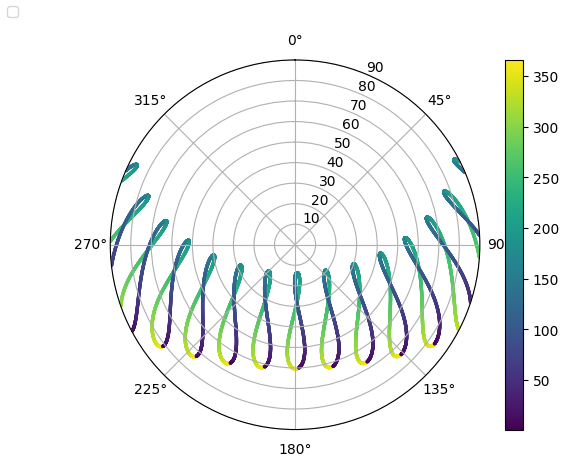

In [65]:
tz = 'America/Los_Angeles'
lat, lon = avg_latitude, avg_longitude

times = pd.date_range(df1['Date'].min(), df1['Date'].max(), freq='H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

ax = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

# # draw hour labels
# for hour in np.unique(solpos.index.hour):
#     # choose label position by the smallest radius for each hour
#     subset = solpos.loc[solpos.index.hour == hour, :]
#     r = subset.apparent_zenith
#     pos = solpos.loc[r.idxmin(), :]
#     ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

# # draw individual days
# for date in df1['Date']:
#     times = pd.date_range(date, date+pd.Timedelta('24h'), freq='H', tz=tz)
#     solpos = solarposition.get_solarposition(times, lat, lon)
#     solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
#     label = date.strftime('%Y-%m-%d')
#     ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)

ax.figure.legend(loc='upper left')

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

## Opening the retrieved location data

In [66]:
# Specify the path to your CSV file
csv_file_path = 'history_bulk_location.csv'

# Read the CSV file and create a DataFrame
df2 = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df2.head())

           dt                         dt_iso  timezone        city_name  \
0  1589500800  2020-05-15 00:00:00 +0000 UTC    -25200  Custom location   
1  1589504400  2020-05-15 01:00:00 +0000 UTC    -25200  Custom location   
2  1589508000  2020-05-15 02:00:00 +0000 UTC    -25200  Custom location   
3  1589511600  2020-05-15 03:00:00 +0000 UTC    -25200  Custom location   
4  1589515200  2020-05-15 04:00:00 +0000 UTC    -25200  Custom location   

         lat         lon   temp  visibility  dew_point  feels_like  ...  \
0  37.051548 -120.699371  24.14         NaN      12.77       23.89  ...   
1  37.051548 -120.699371  23.75         NaN      13.02       23.51  ...   
2  37.051548 -120.699371  21.51         NaN      13.93       21.34  ...   
3  37.051548 -120.699371  20.67         NaN      13.86       20.49  ...   
4  37.051548 -120.699371  18.86         NaN      13.92       18.71  ...   

   wind_gust  rain_1h  rain_3h  snow_1h  snow_3h  clouds_all  weather_id  \
0        NaN      NaN 

In [67]:
# Get the number of columns and rows
num_columns = df2.shape[1]
num_rows = df2.shape[0]

# Display the number of columns and rows
print("Number of columns:", num_columns)
print("Number of rows:", num_rows)

Number of columns: 28
Number of rows: 26304


In [68]:
# Find duplicate records
duplicates = df2.duplicated()
# Print the number of duplicate records
print('Number of duplicate records:', duplicates.sum())

Number of duplicate records: 0


In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   26304 non-null  int64  
 1   dt_iso               26304 non-null  object 
 2   timezone             26304 non-null  int64  
 3   city_name            26304 non-null  object 
 4   lat                  26304 non-null  float64
 5   lon                  26304 non-null  float64
 6   temp                 26304 non-null  float64
 7   visibility           0 non-null      float64
 8   dew_point            26299 non-null  float64
 9   feels_like           26304 non-null  float64
 10  temp_min             26304 non-null  float64
 11  temp_max             26304 non-null  float64
 12  pressure             26304 non-null  int64  
 13  sea_level            0 non-null      float64
 14  grnd_level           0 non-null      float64
 15  humidity             26304 non-null 

In [70]:
df2.isnull().sum()

dt                         0
dt_iso                     0
timezone                   0
city_name                  0
lat                        0
lon                        0
temp                       0
visibility             26304
dew_point                  5
feels_like                 0
temp_min                   0
temp_max                   0
pressure                   0
sea_level              26304
grnd_level             26304
humidity                   0
wind_speed                 0
wind_deg                   0
wind_gust              26304
rain_1h                25188
rain_3h                26304
snow_1h                26304
snow_3h                26304
clouds_all                 0
weather_id                 0
weather_main               0
weather_description        0
weather_icon               0
dtype: int64

Cleaning the retrieved dataset

In [71]:
# List of column names to drop
columns_to_drop = ['dt','timezone','visibility',
                   'sea_level', 'grnd_level', 'wind_gust',
                   'rain_1h' ,'rain_3h', 'snow_1h','snow_3h']

# Drop the specified columns
df2 = df2.drop(columns=columns_to_drop)

# Remove '+0000 UTC' from 'dt_iso' column
df2['dt_iso'] = df2['dt_iso'].str.replace('+0000 UTC', '')

# Convert 'dt_iso' column to datetime64[ns]
df2['dt_iso'] = pd.to_datetime(df2['dt_iso'])

# Adjusting the time to UTC-7 due to the location
df2['dt_iso'] = df2['dt_iso'] - timedelta(hours=7)

# Replace all values in 'city_name' column with 'Dos Palos' instead of 'Custom location'
df2['city_name'] = 'Dos Palos Y'

# Get the number of columns and rows
num_columns = df2.shape[1]
num_rows = df2.shape[0]

# Display the number of columns and rows
print("Number of columns:", num_columns)
print("Number of rows:", num_rows)

# Display the updated DataFrame
print(df2.head())

Number of columns: 18
Number of rows: 26304
               dt_iso    city_name        lat         lon   temp  dew_point  \
0 2020-05-14 17:00:00  Dos Palos Y  37.051548 -120.699371  24.14      12.77   
1 2020-05-14 18:00:00  Dos Palos Y  37.051548 -120.699371  23.75      13.02   
2 2020-05-14 19:00:00  Dos Palos Y  37.051548 -120.699371  21.51      13.93   
3 2020-05-14 20:00:00  Dos Palos Y  37.051548 -120.699371  20.67      13.86   
4 2020-05-14 21:00:00  Dos Palos Y  37.051548 -120.699371  18.86      13.92   

   feels_like  temp_min  temp_max  pressure  humidity  wind_speed  wind_deg  \
0       23.89     23.28     25.13      1017        49        4.01       295   
1       23.51     22.21     24.50      1016        51        4.24       291   
2       21.34     21.11     23.40      1016        62        4.47       288   
3       20.49     19.85     22.19      1017        65        3.93       285   
4       18.71     18.33     20.16      1017        73        3.68       282   

   clo

## Joining the two datasets together

In [72]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  26193 non-null  datetime64[ns]
 1   Date      26193 non-null  datetime64[ns]
 2   Hour      26193 non-null  int64         
 3   Actual    26193 non-null  int64         
dtypes: datetime64[ns](2), int64(2)
memory usage: 818.7 KB


In [73]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt_iso               26304 non-null  datetime64[ns]
 1   city_name            26304 non-null  object        
 2   lat                  26304 non-null  float64       
 3   lon                  26304 non-null  float64       
 4   temp                 26304 non-null  float64       
 5   dew_point            26299 non-null  float64       
 6   feels_like           26304 non-null  float64       
 7   temp_min             26304 non-null  float64       
 8   temp_max             26304 non-null  float64       
 9   pressure             26304 non-null  int64         
 10  humidity             26304 non-null  int64         
 11  wind_speed           26304 non-null  float64       
 12  wind_deg             26304 non-null  int64         
 13  clouds_all           26304 non-

In [74]:
# Perform the left join
data = pd.merge(df1, df2, left_on='DateTime', right_on='dt_iso', how='left')

# Drop the specified columns
data = data.drop(columns='dt_iso')

# Convert Datetime object to Datetime object with time zone (this is needed for proper merging with GHI dataframe)
data.set_index('DateTime',inplace=True)
data = data.tz_localize(tz="America/Los_Angeles", ambiguous='NaT')
data['DateTime'] = data.index
data.reset_index(drop=True, inplace = True)

# Display the merged DataFramedf1
print(data)

            Date  Hour  Actual    city_name        lat         lon   temp  \
0     2020-05-16     1       0  Dos Palos Y  37.051548 -120.699371  16.31   
1     2020-05-16     2       0  Dos Palos Y  37.051548 -120.699371  15.83   
2     2020-05-16     3       0  Dos Palos Y  37.051548 -120.699371  15.69   
3     2020-05-16     4       0  Dos Palos Y  37.051548 -120.699371  14.30   
4     2020-05-16     5       0  Dos Palos Y  37.051548 -120.699371  14.27   
...          ...   ...     ...          ...        ...         ...    ...   
26188 2023-05-14    20     874  Dos Palos Y  37.051548 -120.699371  23.44   
26189 2023-05-14    21       0  Dos Palos Y  37.051548 -120.699371  22.27   
26190 2023-05-14    22       3  Dos Palos Y  37.051548 -120.699371  21.43   
26191 2023-05-14    23       7  Dos Palos Y  37.051548 -120.699371  19.90   
26192 2023-05-14    24       6  Dos Palos Y  37.051548 -120.699371  17.88   

       dew_point  feels_like  temp_min  ...  pressure  humidity  wind_speed

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   Date                 26193 non-null  datetime64[ns]                     
 1   Hour                 26193 non-null  int64                              
 2   Actual               26193 non-null  int64                              
 3   city_name            26193 non-null  object                             
 4   lat                  26193 non-null  float64                            
 5   lon                  26193 non-null  float64                            
 6   temp                 26193 non-null  float64                            
 7   dew_point            26188 non-null  float64                            
 8   feels_like           26193 non-null  float64                            
 9   temp_min             26193 n

## Cleaning memory usage

In [76]:
# # Get all variables in the current scope
# all_variables = list(locals().keys())

# # Delete all variables except 'merged_df'
# for variable in all_variables:
#     if variable != 'data':
#         del locals()[variable]

# # Display the merged DataFrame
# print(data)

In [77]:
print(data.head())

        Date  Hour  Actual    city_name        lat         lon   temp  \
0 2020-05-16     1       0  Dos Palos Y  37.051548 -120.699371  16.31   
1 2020-05-16     2       0  Dos Palos Y  37.051548 -120.699371  15.83   
2 2020-05-16     3       0  Dos Palos Y  37.051548 -120.699371  15.69   
3 2020-05-16     4       0  Dos Palos Y  37.051548 -120.699371  14.30   
4 2020-05-16     5       0  Dos Palos Y  37.051548 -120.699371  14.27   

   dew_point  feels_like  temp_min  ...  pressure  humidity  wind_speed  \
0       7.53       15.46     14.41  ...      1015        56        2.16   
1       7.59       14.98     13.30  ...      1014        58        1.97   
2       7.46       14.83     12.75  ...      1014        58        1.73   
3       7.82       13.48     12.75  ...      1014        65        1.72   
4       8.23       13.50     12.19  ...      1014        67        2.06   

   wind_deg  clouds_all  weather_id  weather_main weather_description  \
0       249          83         803  

In [78]:
print(data.tail())

            Date  Hour  Actual    city_name        lat         lon   temp  \
26188 2023-05-14    20     874  Dos Palos Y  37.051548 -120.699371  23.44   
26189 2023-05-14    21       0  Dos Palos Y  37.051548 -120.699371  22.27   
26190 2023-05-14    22       3  Dos Palos Y  37.051548 -120.699371  21.43   
26191 2023-05-14    23       7  Dos Palos Y  37.051548 -120.699371  19.90   
26192 2023-05-14    24       6  Dos Palos Y  37.051548 -120.699371  17.88   

       dew_point  feels_like  temp_min  ...  pressure  humidity  wind_speed  \
26188      10.50       22.99     23.33  ...      1010        44        2.65   
26189       9.10       21.68     21.77  ...      1011        43        2.34   
26190       9.66       20.86     20.66  ...      1012        47        1.97   
26191      10.87       19.41     18.43  ...      1013        56        1.86   
26192      10.75       17.37     17.22  ...      1014        63        2.07   

       wind_deg  clouds_all  weather_id  weather_main weather_

In [79]:
# Setting the coordinates
lat, long, alt = avg_latitude, avg_longitude, avg_altitude

#create location instance to be used for generating HI data
location = pvlib_location.Location(latitude=lat,longitude=long, tz="America/Los_Angeles")


#create time range to use for generating HI data
time = pd.date_range(start='5/16/2020', end='5/15/2023', tz=location.tz, freq='1H')
time_ = pd.date_range(start='5/16/2020', end='5/15/2023', freq='1H')

#generate HI data and formate the df
HI = location.get_clearsky(time)
HI['DateTime_DST'] = time
HI['DateTime']=time_
HI.reset_index(drop=True,inplace=True)
HI['Hour'] = HI['DateTime'].apply(lambda x:x.hour)
HI['Hour_DST'] = HI['DateTime_DST'].apply(lambda x:x.hour)
HI['Hour'].replace(0, 24, inplace=True)
#HI.loc[HI['Hour']==24, 'DateTime'] = HI.loc[HI['Hour']==24, 'DateTime'].apply(lambda x:x-timedelta(days=1))
#HI.loc[HI['Hour']==24, 'DateTime_DST'] = HI.loc[HI['Hour']==24, 'DateTime_DST'].apply(lambda x:x-timedelta(days=1))
HI['year'] = HI['DateTime'].apply(lambda x:x.year)
HI['month'] = HI['DateTime'].apply(lambda x:x.month)
HI['week'] = HI['DateTime'].apply(lambda x:x.isocalendar().week)
HI['day'] = HI['DateTime'].apply(lambda x:x.day)

HI = HI.drop(labels=0, axis=0)
HI.reset_index(drop=True,inplace=True)

In [80]:
# Perform the left join
data_full = pd.merge(data, HI, left_on='DateTime', right_on='DateTime_DST', how='left')

# Drop the specified columns
data_full = data_full.drop(columns=['DateTime_y'])
data_full.rename(columns = {'Hour_x':'Hour_actual', 'DateTime_x':'DateTime','Hour_y':'Hour'}, inplace = True)
data_full.dropna(inplace=True)

#forcing negative values to 0
data_full.loc[data_full['Actual']<=0, 'Actual']=0

In [81]:
#data_full.to_csv('full_data.csv', encoding='utf-8')

## Full Data Explanatory Analysis

In [82]:
#Printing the dataset
data_full

Date  Hour_actual  Actual    city_name        lat         lon  \
0     2020-05-16            1       0  Dos Palos Y  37.051548 -120.699371   
1     2020-05-16            2       0  Dos Palos Y  37.051548 -120.699371   
2     2020-05-16            3       0  Dos Palos Y  37.051548 -120.699371   
3     2020-05-16            4       0  Dos Palos Y  37.051548 -120.699371   
4     2020-05-16            5       0  Dos Palos Y  37.051548 -120.699371   
...          ...          ...     ...          ...        ...         ...   
26188 2023-05-14           20     874  Dos Palos Y  37.051548 -120.699371   
26189 2023-05-14           21       0  Dos Palos Y  37.051548 -120.699371   
26190 2023-05-14           22       3  Dos Palos Y  37.051548 -120.699371   
26191 2023-05-14           23       7  Dos Palos Y  37.051548 -120.699371   
26192 2023-05-14           24       6  Dos Palos Y  37.051548 -120.699371   

        temp  dew_point  feels_like  temp_min  ...       ghi       dni  \
0      16.31       7.53       15.46     14.41  ...  0.000000  0.000000   
1      15.83       7.59       14.98     13.30  ...  0.000000  0.000000   
2      15.69       7.46       14.83     12.75  ...  0.000000  0.000000   
3      14.30       7.82       13.48     12.75  ...  0.000000  0.000000   
4      14.27       8.23       13.50     12.19  ...  0.000000  0.000000   
...      ...        ...         ...       ...  ...       ...       ...   
26188  23.44      10.50       22.99     23.33  ...  0.022971  0.069806   
26189  22.27       9.10       21.68     21.77  ...  0.000000  0.000000   
26190  21.43       9.66       20.86     20.66  ...  0.000000  0.000000   
26191  19.90      10.87       19.41     18.43  ...  0.000000  0.000000   
26192  17.88      10.75       17.37     17.22  ...  0.000000  0.000000   

           dhi              DateTime_DST  Hour  Hour_DST    year month  week  \
0      0.00000 2020-05-16 01:00:00-07:00   1.0       1.0  2020.0   5.0  20.0   
1      0.00000 2020-05-16 02:00:00-07:00   2.0       2.0  2020.0   5.0  20.0   
2      0.00000 2020-05-16 03:00:00-07:00   3.0       3.0  2020.0   5.0  20.0   
3      0.00000 2020-05-16 04:00:00-07:00   4.0       4.0  2020.0   5.0  20.0   
4      0.00000 2020-05-16 05:00:00-07:00   5.0       5.0  2020.0   5.0  20.0   
...        ...                       ...   ...       ...     ...   ...   ...   
26188  0.02264 2023-05-14 20:00:00-07:00  20.0      20.0  2023.0   5.0  19.0   
26189  0.00000 2023-05-14 21:00:00-07:00  21.0      21.0  2023.0   5.0  19.0   
26190  0.00000 2023-05-14 22:00:00-07:00  22.0      22.0  2023.0   5.0  19.0   
26191  0.00000 2023-05-14 23:00:00-07:00  23.0      23.0  2023.0   5.0  19.0   
26192  0.00000 2023-05-15 00:00:00-07:00  24.0       0.0  2023.0   5.0  20.0   

        day  
0      16.0  
1      16.0  
2      16.0  
3      16.0  
4      16.0  
...     ...  
26188  14.0  
26189  14.0  
26190  14.0  
26191  14.0  
26192  15.0  

[26185 rows x 31 columns]

In [83]:
data_full.columns

Index(['Date', 'Hour_actual', 'Actual', 'city_name', 'lat', 'lon', 'temp',
       'dew_point', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id',
       'weather_main', 'weather_description', 'weather_icon', 'DateTime',
       'ghi', 'dni', 'dhi', 'DateTime_DST', 'Hour', 'Hour_DST', 'year',
       'month', 'week', 'day'],
      dtype='object')

In [84]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26185 entries, 0 to 26192
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype                              
---  ------               --------------  -----                              
 0   Date                 26185 non-null  datetime64[ns]                     
 1   Hour_actual          26185 non-null  int64                              
 2   Actual               26185 non-null  int64                              
 3   city_name            26185 non-null  object                             
 4   lat                  26185 non-null  float64                            
 5   lon                  26185 non-null  float64                            
 6   temp                 26185 non-null  float64                            
 7   dew_point            26185 non-null  float64                            
 8   feels_like           26185 non-null  float64                            
 9   temp_min             26185 non-nu

## Exploring Actual power generation and GHI

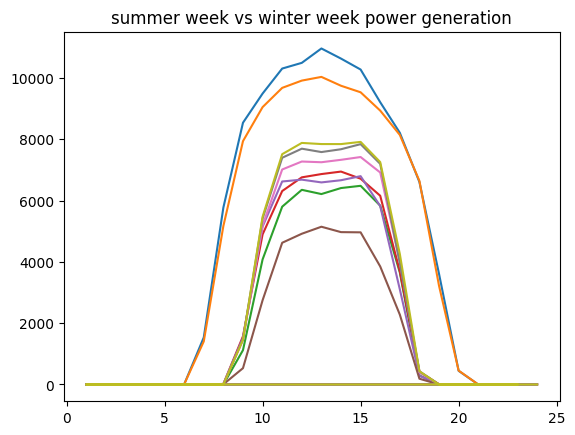

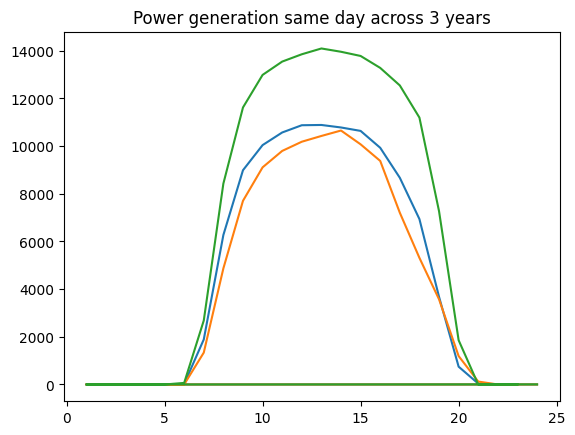

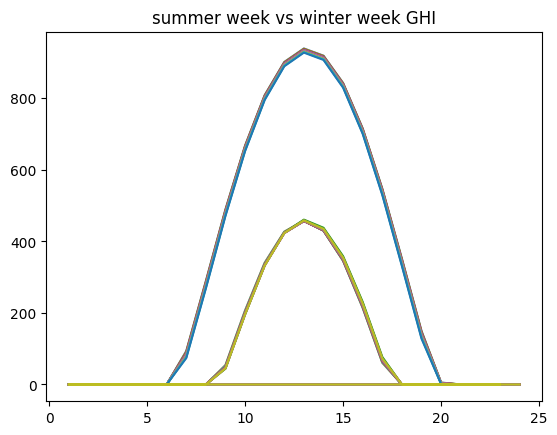

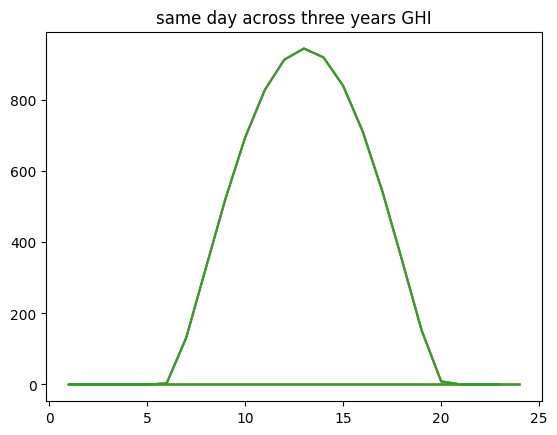

In [85]:
#summer week vs winter week power generation
plt.figure()
plt.title('summer week vs winter week power generation')
for y in [2020]:
    data_y = data_full[data_full['year']==y].copy()

    for i in [20,51]:
        data_w = data_y[data_y['week']==i].copy()
    #     plt.figure()
        for j in data_w['day'].unique():
            plt.plot(data_w[data_w['day']==j]['Hour'],data_w[data_w['day']==j]['Actual'])
    
    
    

#same day across three years power generation
#day weather may be important to consider
plt.figure()
plt.title('Power generation same day across 3 years')
for i in [6]:
    data_m = data_full[data_full['month']==i].copy()

    for y in [2020,2021,2022]:
        data_y = data_m[data_m['year']==y].copy()
    
        for j in [15]:
            plt.plot(data_y[data_y['day']==j]['Hour'],data_y[data_y['day']==j]['Actual'])

            
            

#summer week vs winter week ghi
#similar observation to power generation
plt.figure()
plt.title('summer week vs winter week GHI')
for y in [2020,2022]:
    data_y_ = data_full[data_full['year']==y].copy()

    for i in [30,52]:
        data_w_ = data_y_[data_y_['week']==i].copy()
    #     plt.figure()
        for j in data_w_['day'].unique():
            plt.plot(data_w_[data_w_['day']==j]['Hour'],data_w_[data_w_['day']==j]['ghi'])

            

#same day across three years GHI
#clearsky GHI is not affected by day weather, therefore, day weather from external source may be important to consider
plt.figure()
plt.title('same day across three years GHI')
for i in [6]:
    data_m = HI[HI['month']==i].copy()

    for y in [2020,2021,2022]:
        data_y = data_m[data_m['year']==y].copy()
    
        for j in [15]:
            plt.plot(data_y[data_y['day']==j]['Hour'],data_y[data_y['day']==j]['ghi'])

## Exploring GHI and cloud cover effect on actual power generation

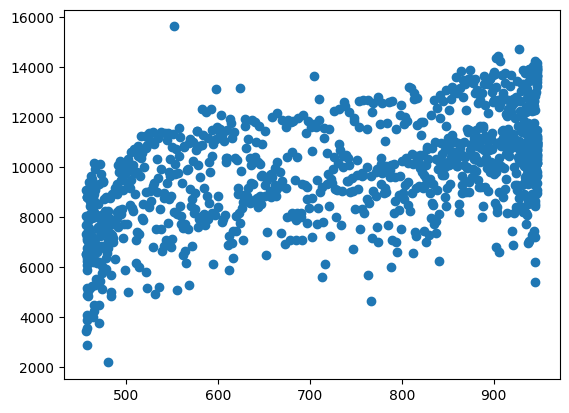

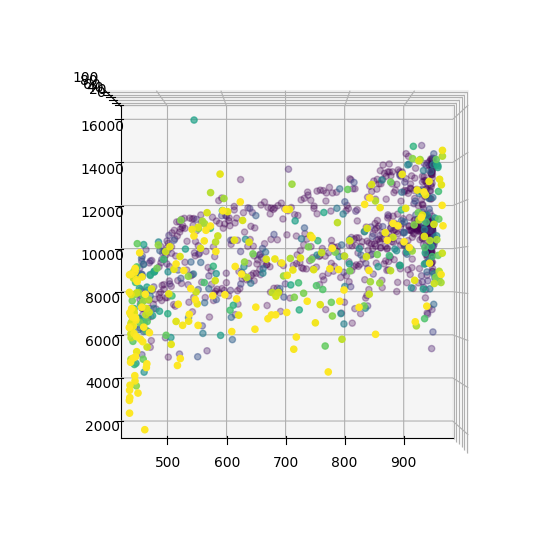

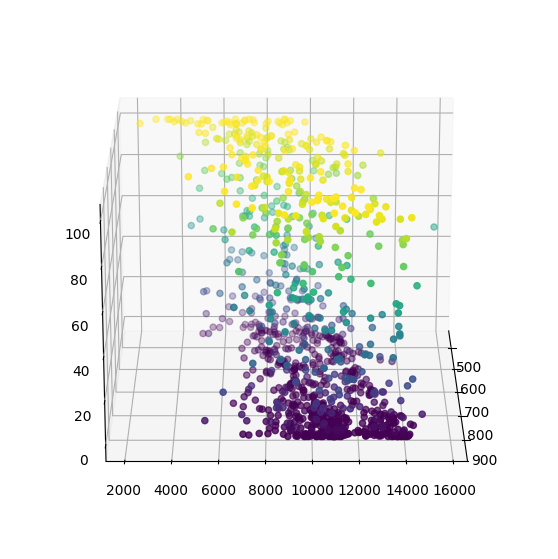

In [86]:

#Exploring GHI and cloud cover effect on actual power generation

filtered = data_full.copy()
filtered = filtered[filtered['Hour']==13].copy()
filtered = filtered[filtered['clouds_all']<=100].copy()

x = filtered['ghi'].copy()
y = filtered['Actual'].copy()
z = filtered['clouds_all'].copy()

#Correlation between daily GHI at 13:00 pm & actual power generation (try changing time to 7:00 am & 19:00 pm)
plt.scatter(x,y)


#same correlation as above but on 3d plot with "clouds_all" in z direction
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=z)
ax.view_init(90,-90 )


#Correlation between actual power generation at 13:00 pm & cloud cover (try changing time to 7:00 am & 19:00 pm)
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=z)
ax.view_init(20, 0)


## 3 weeks actual power generation & cloud cover
### Time series is a potential modeling approach

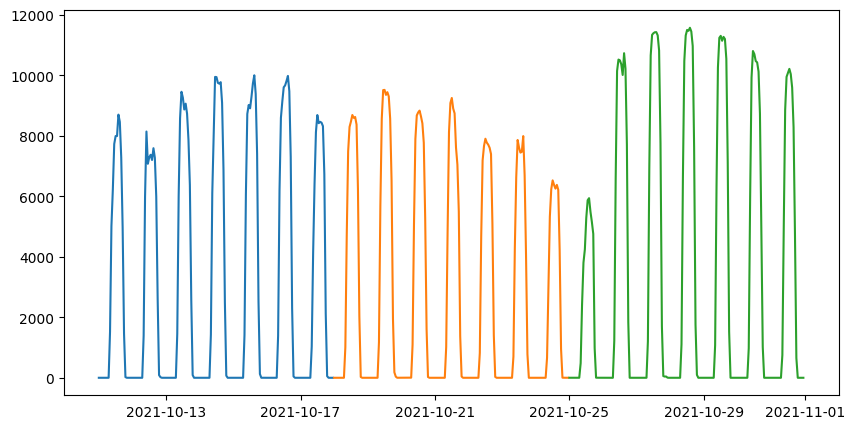

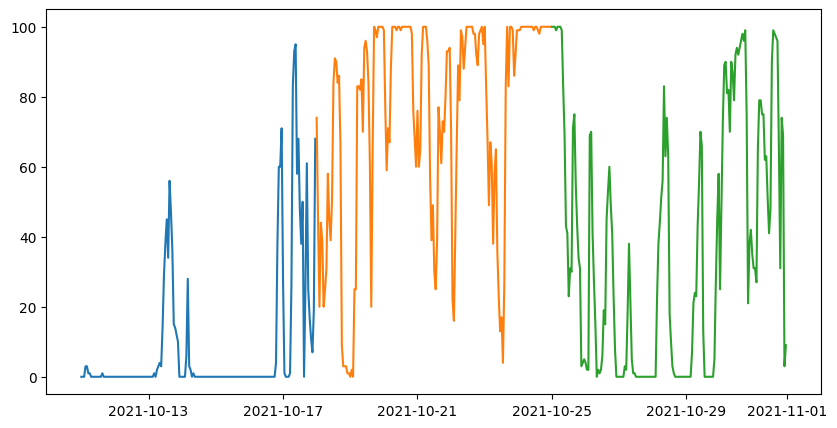

In [87]:
#Time series is a potential modeling approach 


plt.figure(figsize=(10,5))
for y in [2021]:
    data_y = data_full[data_full['year']==y].copy()
    #data_y = data_y[data_y['DateTime']!=24].copy()
    

    for i in [41,42,43]:
        data_w = data_y[data_y['week']==i].copy()
        #data_w.drop(data_w.tail(1).index,inplace=True)
        plt.plot(data_w['DateTime'],data_w['Actual'])
            
        
plt.figure(figsize=(10,5))
for y in [2021]:
    data_y = data_full[data_full['year']==y].copy()
    #data_y = data_y[data_y['Hour']!=24].copy()
    

    for i in [41,42,43]:
        data_w = data_y[data_y['week']==i].copy()
        #data_w.drop(data_w.tail(1).index,inplace=True)
        plt.plot(data_w['DateTime'],data_w['clouds_all'])
        
        
# plt.figure(figsize=(10,5))
# for y in [2021]:
#     data_y = data_full[data_full['year']==y].copy()
#     #data_y = data_y[data_y['Hour']!=24].copy()
    

#     for i in [41,42,43]:
#         data_w = data_y[data_y['week']==i].copy()
#         #data_w.drop(data_w.tail(1).index,inplace=True)
#         plt.plot(data_w['DateTime'],data_w['temp'])

## Data Engineering

In [88]:
import seaborn as sns
# sns.pairplot(data_full)

Based on the above graph, we can see some patterns in the data which would indicate some correlation among some variables.

Generating a correlation matrix

<Axes: >

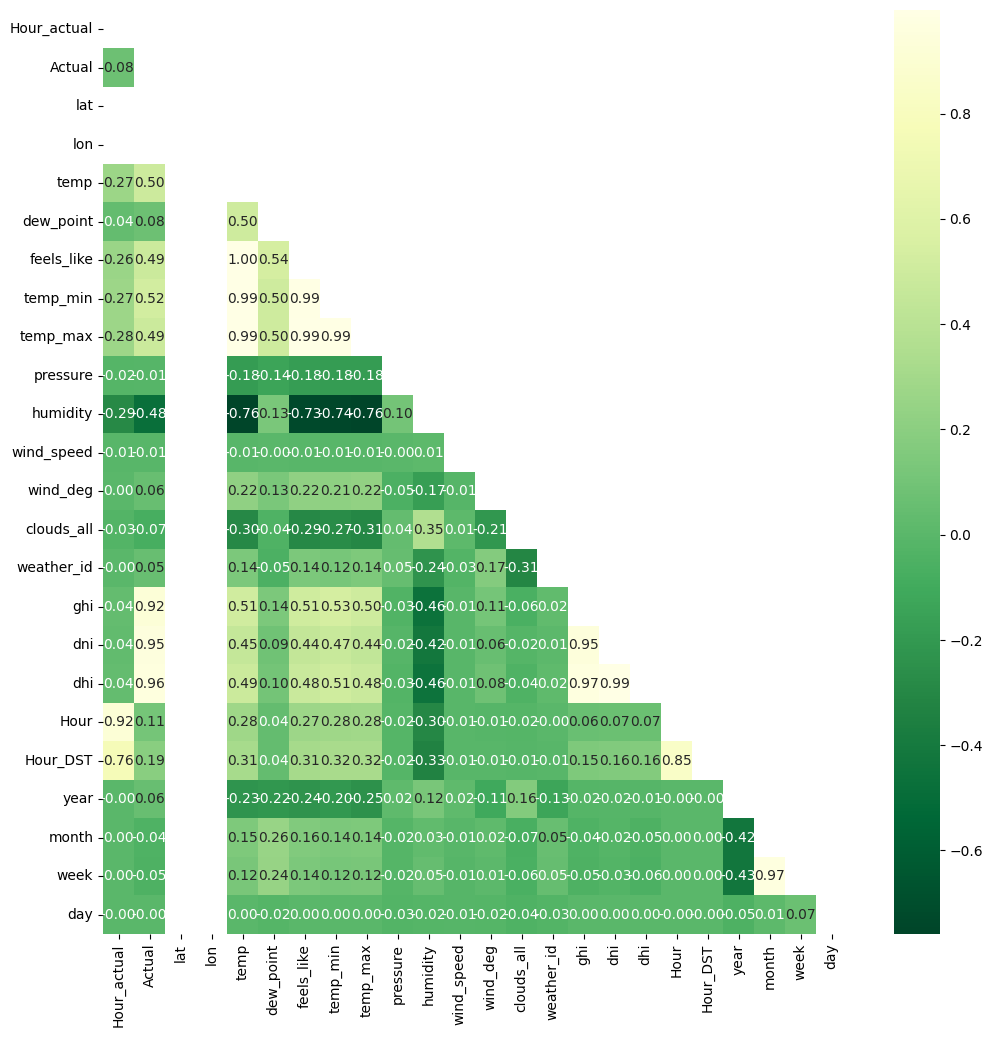

In [135]:
# copying the data_full
subset = data_full.copy()

# Specify the columns to drop
columns_todrop = ['DateTime', 'Date', 'DateTime_DST', 'city_name', 
                  'weather_main', 'weather_description', 'weather_icon']

# Drop the specified columns from the DataFrame
subset = subset.drop(columns=columns_todrop, axis=1)

# Generate the heatmap with increased size
plt.figure(figsize=(12,12))

# Plot the correlation
mask = np.triu(np.ones_like(subset.corr()))
sns.heatmap(subset.corr(), mask=mask, annot=True, fmt='.2f', cmap='YlGn_r')

From the correlation matrix, we ca see that we would need to remove some variables:

We will remove the below variables as their percentage is greater than 80%:

    -All of the DST timestamp as we have a timestamp with date + hour
    -Week as we have date column
    -month as we have date column
    -dni and dhi as both are used to calculate ghi
    -weather id as we have the weather details
    -feels like as we have the exact temperature
    -temp min

In [90]:
import pandas as pd

# Create a copy of the original dataframe
final_df = data_full.copy()

# Remove the specified columns
columns_to_remove = ['DateTime_DST', 'Hour_DST', 'week', 
                     'Date', 'dni', 'dhi', 'temp_min', 
                     'feels_like', 'weather_id',
                     'city_name', 'lat', 'lon']

final_df.drop(columns=columns_to_remove, inplace=True)

# changing the index
final_df.set_index('DateTime', inplace=True)

# Reorder columns alphabetically
final_df = final_df.reindex(sorted(final_df.columns), axis=1)

# Move 'ghi' column to the first position
columns = final_df.columns.tolist()
columns.insert(0, columns.pop(columns.index('Actual')))
final_df = final_df[columns]

# Print the resulting dataframe
print(final_df)


                           Actual  Hour  Hour_actual  clouds_all   day  \
DateTime                                                                 
2020-05-16 01:00:00-07:00       0   1.0            1          83  16.0   
2020-05-16 02:00:00-07:00       0   2.0            2          87  16.0   
2020-05-16 03:00:00-07:00       0   3.0            3          95  16.0   
2020-05-16 04:00:00-07:00       0   4.0            4          88  16.0   
2020-05-16 05:00:00-07:00       0   5.0            5          76  16.0   
...                           ...   ...          ...         ...   ...   
2023-05-14 20:00:00-07:00     874  20.0           20           0  14.0   
2023-05-14 21:00:00-07:00       0  21.0           21           0  14.0   
2023-05-14 22:00:00-07:00       3  22.0           22           0  14.0   
2023-05-14 23:00:00-07:00       7  23.0           23           0  14.0   
2023-05-15 00:00:00-07:00       6  24.0           24           1  15.0   

                           dew_point 

In [91]:
final_df.columns

Index(['Actual', 'Hour', 'Hour_actual', 'clouds_all', 'day', 'dew_point',
       'ghi', 'humidity', 'month', 'pressure', 'temp', 'temp_max',
       'weather_description', 'weather_icon', 'weather_main', 'wind_deg',
       'wind_speed', 'year'],
      dtype='object')

In [92]:
# Identify categorical and numerical columns
CAT = final_df.select_dtypes(include=['object']).columns.tolist()
NUM = final_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print the categorical and numerical columns
print("Categorical Columns:", CAT)
print("Numerical Columns:", NUM)


Categorical Columns: ['weather_description', 'weather_icon', 'weather_main']
Numerical Columns: ['Actual', 'Hour', 'Hour_actual', 'clouds_all', 'day', 'dew_point', 'ghi', 'humidity', 'month', 'pressure', 'temp', 'temp_max', 'wind_deg', 'wind_speed', 'year']


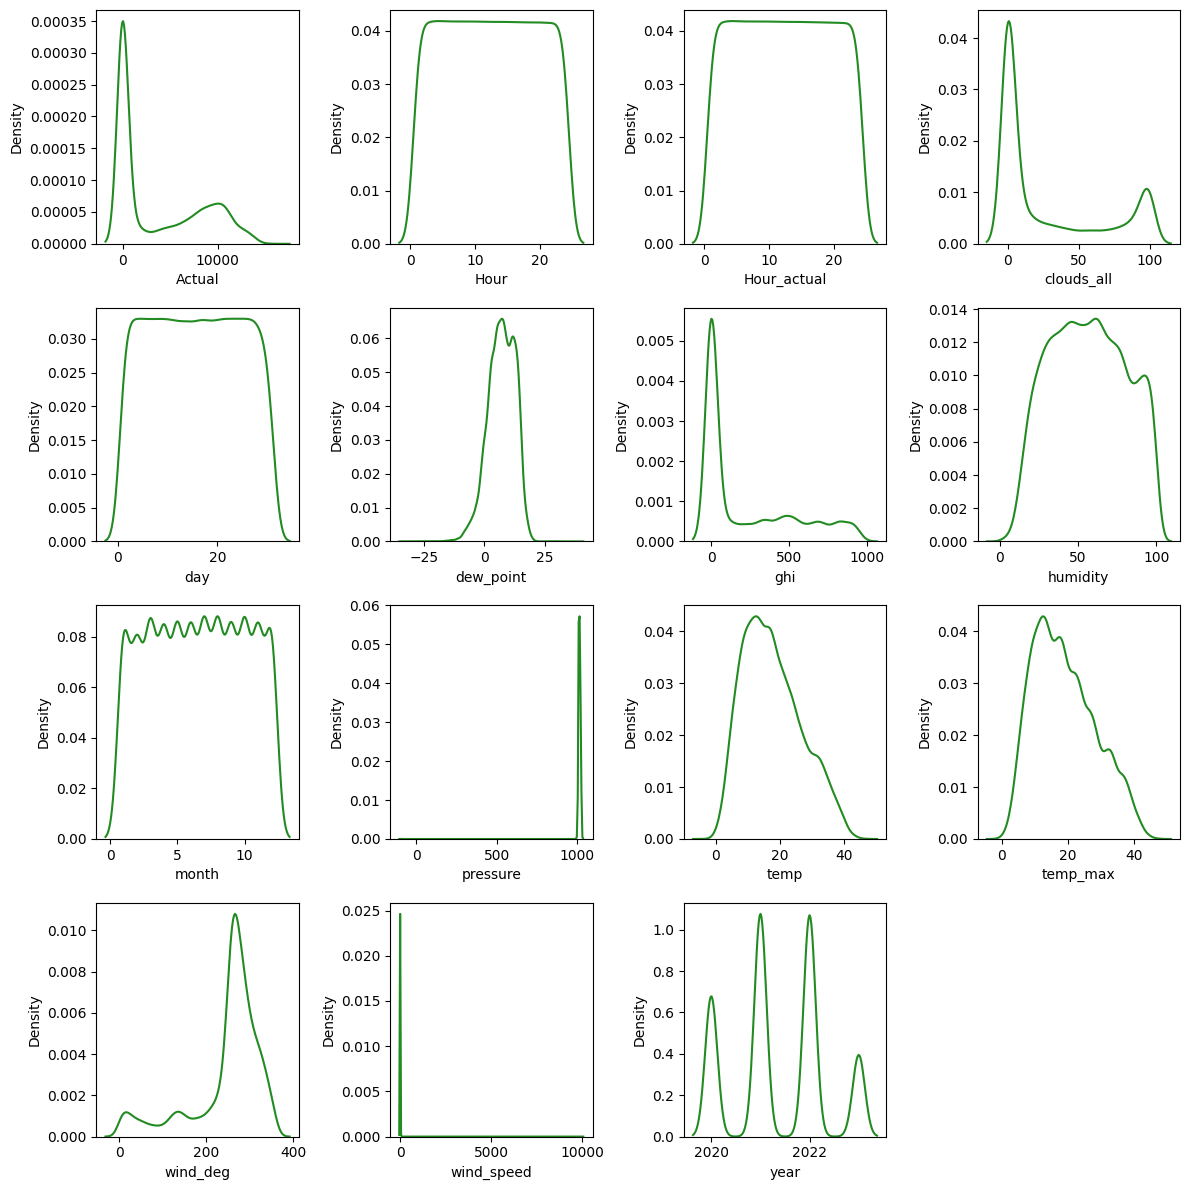

In [93]:
# Select only the numerical columns
num_df = final_df.select_dtypes(include=['int64', 'float64']).reset_index()

#plotting
plt.figure(figsize=(12,12))
for i in range(1, len(num_df.columns)):
    plt.subplot(4,4,i)
    sns.kdeplot(x=num_df[num_df.columns[i]], label='train', color='forestgreen')
    plt.tight_layout()

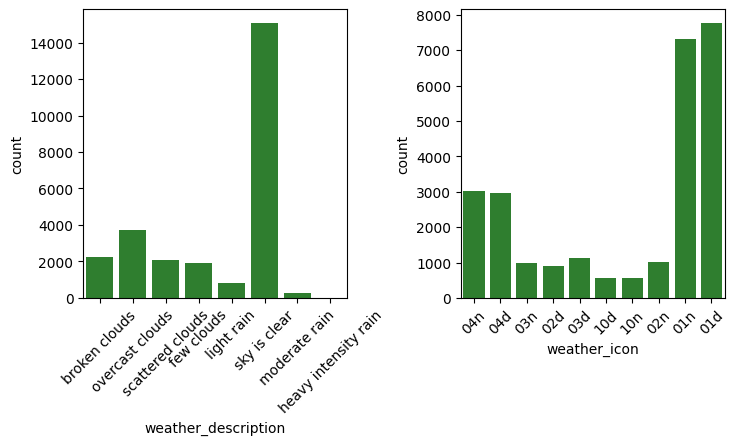

In [94]:
plt.figure(figsize=(15, 12))

for i in range(0, len(CAT[:-1])):
    plt.subplot(3, 4, i+1)
    ax = sns.countplot(x=final_df[CAT[i]], color='forestgreen')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

<Axes: >

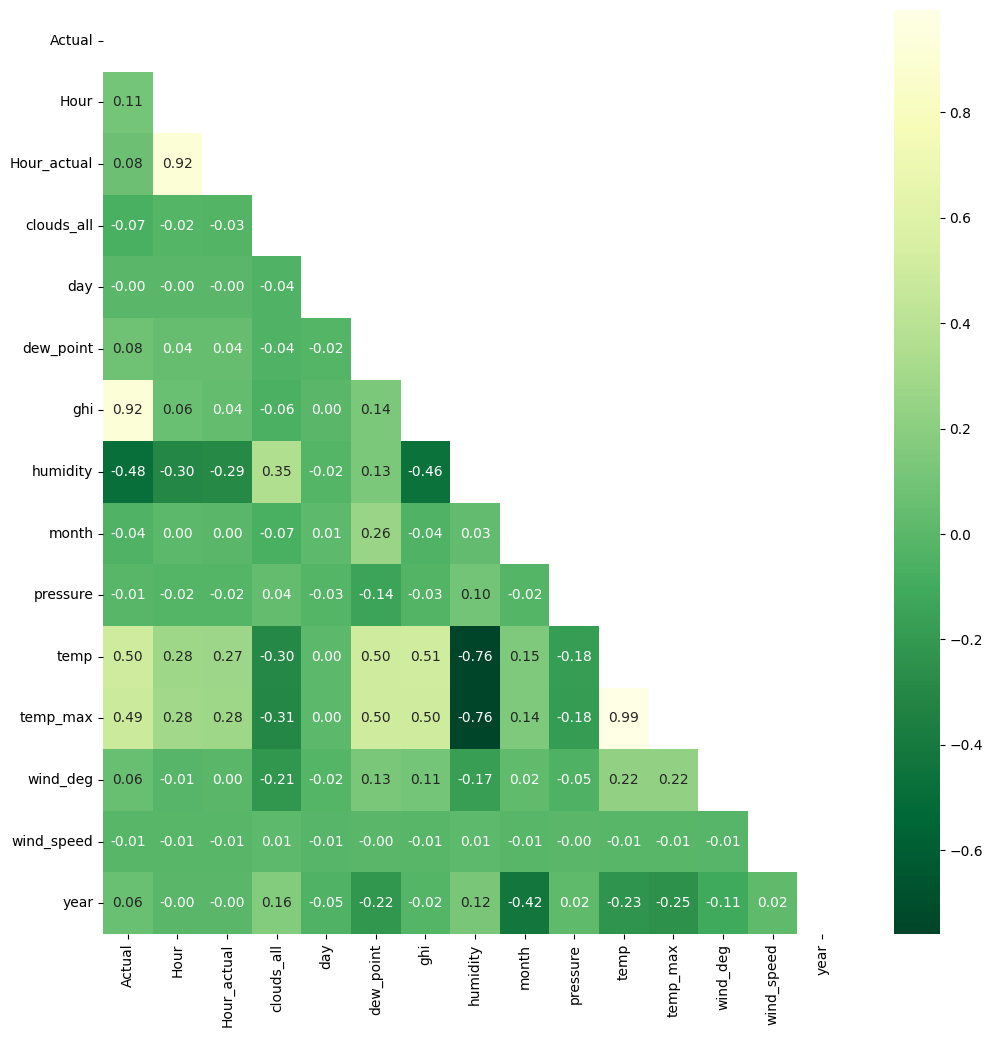

In [95]:
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(final_df[NUM].corr()))
sns.heatmap(final_df[NUM].corr(), mask=mask, annot=True, fmt='.2f', cmap='YlGn_r')

## Data Processing

In [96]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Combine numeric and categorical features
FEATURES = NUM + CAT

# Fill missing values with mean for numeric variables
imputer = SimpleImputer(strategy='mean')
numeric_df = pd.DataFrame(imputer.fit_transform(final_df[NUM]), columns=NUM)

# Scale numeric variables using min-max scaling
scaler = MinMaxScaler()
scaled_numeric_df = pd.DataFrame(scaler.fit_transform(numeric_df), columns=NUM)

# Encode categorical variables using one-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cat_df = pd.DataFrame(encoder.fit_transform(final_df[CAT]), columns=encoder.get_feature_names_out(CAT))

# Concatenate the scaled numeric and encoded categorical variables
processed_df = pd.concat([scaled_numeric_df, encoded_cat_df], axis=1)

In [97]:
processed_df.head(5)

Actual      Hour  Hour_actual  clouds_all  day  dew_point  ghi  humidity  \
0     0.0  0.000000     0.000000        0.83  0.5   0.565217  0.0  0.555556   
1     0.0  0.043478     0.043478        0.87  0.5   0.566048  0.0  0.575758   
2     0.0  0.086957     0.086957        0.95  0.5   0.564248  0.0  0.575758   
3     0.0  0.130435     0.130435        0.88  0.5   0.569233  0.0  0.646465   
4     0.0  0.173913     0.173913        0.76  0.5   0.574910  0.0  0.666667   

      month  pressure  ...  weather_icon_02n  weather_icon_03d  \
0  0.363636  0.984982  ...               0.0               0.0   
1  0.363636  0.984099  ...               0.0               0.0   
2  0.363636  0.984099  ...               0.0               0.0   
3  0.363636  0.984099  ...               0.0               0.0   
4  0.363636  0.984099  ...               0.0               0.0   

   weather_icon_03n  weather_icon_04d  weather_icon_04n  weather_icon_10d  \
0               0.0               0.0               1.0               0.0   
1               0.0               0.0               1.0               0.0   
2               0.0               0.0               1.0               0.0   
3               0.0               0.0               1.0               0.0   
4               0.0               0.0               1.0               0.0   

   weather_icon_10n  weather_main_Clear  weather_main_Clouds  \
0               0.0                 0.0                  1.0   
1               0.0                 0.0                  1.0   
2               0.0                 0.0                  1.0   
3               0.0                 0.0                  1.0   
4               0.0                 0.0                  1.0   

   weather_main_Rain  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 36 columns]

In [98]:
processed_df.shape

(26185, 36)

## Data Modeling

In [99]:
from sklearn.model_selection import train_test_split

# copying
df = processed_df.copy()

X = df.drop('Actual', axis=1)
y = df['Actual'].copy()

# Split dataset into train and test
#X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)
X_train = X.copy()[:-2930]
y_train = y.copy()[:-2930]
X_test = X.copy()[-2930:]
y_test = y.copy()[-2930:]



# check the shapes of the training and test data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
X_train

X_train shape: (23255, 35)
y_train shape: (23255,)
X_test shape: (2930, 35)
y_test shape: (2930,)


Hour  Hour_actual  clouds_all       day  dew_point       ghi  \
0      0.000000     0.000000        0.83  0.500000   0.565217  0.000000   
1      0.043478     0.043478        0.87  0.500000   0.566048  0.000000   
2      0.086957     0.086957        0.95  0.500000   0.564248  0.000000   
3      0.130435     0.130435        0.88  0.500000   0.569233  0.000000   
4      0.173913     0.173913        0.76  0.500000   0.574910  0.000000   
...         ...          ...         ...       ...        ...       ...   
23250  0.521739     0.478261        0.99  0.366667   0.610219  0.502666   
23251  0.565217     0.521739        0.98  0.366667   0.617973  0.482947   
23252  0.608696     0.565217        0.99  0.366667   0.619496  0.402289   
23253  0.652174     0.608696        0.94  0.366667   0.603157  0.269067   
23254  0.695652     0.652174        0.95  0.366667   0.600665  0.104412   

       humidity     month  pressure      temp  ...  weather_icon_02n  \
0      0.555556  0.363636  0.984982  0.396377  ...               0.0   
1      0.575758  0.363636  0.984099  0.386821  ...               0.0   
2      0.575758  0.363636  0.984099  0.384033  ...               0.0   
3      0.646465  0.363636  0.984099  0.356361  ...               0.0   
4      0.666667  0.363636  0.984099  0.355763  ...               0.0   
...         ...       ...       ...       ...  ...               ...   
23250  0.787879  0.000000  0.990283  0.357754  ...               0.0   
23251  0.757576  0.000000  0.989399  0.381246  ...               0.0   
23252  0.666667  0.000000  0.988516  0.423054  ...               0.0   
23253  0.606061  0.000000  0.987633  0.427832  ...               0.0   
23254  0.585859  0.000000  0.986749  0.434601  ...               0.0   

       weather_icon_03d  weather_icon_03n  weather_icon_04d  weather_icon_04n  \
0                   0.0               0.0               0.0               1.0   
1                   0.0               0.0               0.0               1.0   
2                   0.0               0.0               0.0               1.0   
3                   0.0               0.0               0.0               1.0   
4                   0.0               0.0               0.0               1.0   
...                 ...               ...               ...               ...   
23250               0.0               0.0               1.0               0.0   
23251               0.0               0.0               1.0               0.0   
23252               0.0               0.0               1.0               0.0   
23253               0.0               0.0               1.0               0.0   
23254               0.0               0.0               1.0               0.0   

       weather_icon_10d  weather_icon_10n  weather_main_Clear  \
0                   0.0               0.0                 0.0   
1                   0.0               0.0                 0.0   
2                   0.0               0.0                 0.0   
3                   0.0               0.0                 0.0   
4                   0.0               0.0                 0.0   
...                 ...               ...                 ...   
23250               0.0               0.0                 0.0   
23251               0.0               0.0                 0.0   
23252               0.0               0.0                 0.0   
23253               0.0               0.0                 0.0   
23254               0.0               0.0                 0.0   

       weather_main_Clouds  weather_main_Rain  
0                      1.0                0.0  
1                      1.0                0.0  
2                      1.0                0.0  
3                      1.0                0.0  
4                      1.0                0.0  
...                    ...                ...  
23250                  1.0                0.0  
23251                  1.0                0.0  
23252                  1.0                0.0  
23253      

## Multiple Linear Regression

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error


# define the final pipeline that includes the column transformer and a logistic regression model
pipe = Pipeline(steps=[('classifier', LinearRegression())])

In [101]:
# fit the pipeline to the training data
pipe.fit(X_train, y_train)

# evaluate the pipeline on the test data
score = pipe.score(X_test, y_test)
print(f'Test score: {score:.2f}')

Test score: 0.45


In [102]:
# Evaluate the pipeline on the testing data
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f}')

Mean squared error: 0.05


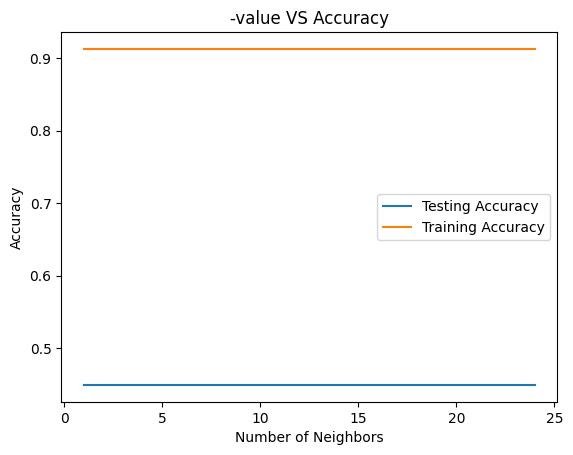

Best accuracy is 0.44956200553511205


In [103]:
# Model complexity
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    lr = LinearRegression()
    # Fit with knn
    lr.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(lr.score(X_train, y_train))
    # test accuracy
    test_accuracy.append(lr.score(X_test, y_test))

# Plot
#plt.figure(figsize=[13,8])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()
print("Best accuracy is {}".format(np.max(test_accuracy)))

In [104]:
# CV
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
k = 10
cv_result = cross_val_score(reg,X_train,y_train,cv=k) # uses R^2 as score 
print('CV Scores: ',cv_result)
print('CV scores average: ',np.sum(cv_result)/k)

CV Scores:  [0.87511419 0.91617013 0.90687536 0.92175607 0.89115576 0.89728031
 0.8753266  0.90326952 0.91543112 0.86845876]
CV scores average:  0.8970837807247722


## XGBoost

In [105]:
# Set the seed for reproducibility
seed_value = 123
random.seed(seed_value)

In [106]:
my_model = xgb.XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

# make predictions
y_pred = my_model.predict(X_test)


# Calculations
print("MAE  : " + str(mean_absolute_error(y_pred, y_test)))
print("RMSE : " + str(mean_squared_error(y_test, y_pred, squared=False)))

MAE  : 0.04405098293473649
RMSE : 0.07767136414929049


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

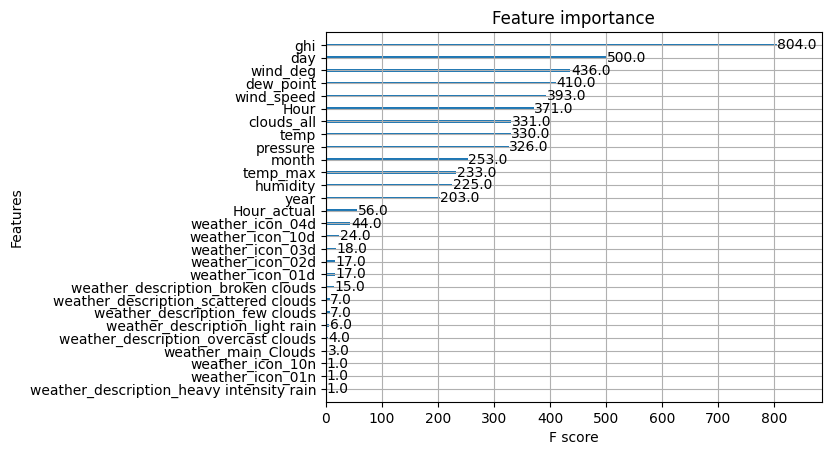

In [107]:
xgb.plot_importance(my_model)

In [108]:
# start_time = time.time()

# Define the objective function for Optuna
def objective(trial):
    
    # Define the search space for hyperparameters 
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'early_stopping_rounds': 100000, # Fix the boosting round and use early stopping
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'lambda': trial.suggest_float('lambda', 0.1, 10.0),
        'alpha': trial.suggest_float('alpha', 0.0, 10.0),
    }
    
    # Split the data into further training and validation sets (three sets are preferable)
    train_data, valid_data, train_target, valid_target = train_test_split(X_train, y_train, test_size=0.22, random_state=42)
    
    # Convert the data into DMatrix format
    dtrain = xgb.DMatrix(train_data, label=train_target)
    dvalid = xgb.DMatrix(valid_data, label=valid_target)
    
    # Define the pruning callback for early stopping
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-rmse')
    
    # Train the model with early stopping
    model = xgb.train(param, dtrain, evals=[(dvalid, 'validation')], callbacks=[pruning_callback])
    
    # Make predictions on the test set
    dtest = xgb.DMatrix(valid_data)
    y_pred = model.predict(dtest)
    
    # Calculate the root mean squared error
    rmse = mean_squared_error(valid_target, y_pred, squared=False)
    
    return rmse


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_value))
study.optimize(objective, n_trials=100) # Control the number of trials

# Print the best hyperparameters and the best RMSE
best_params = study.best_params
best_rmse = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best RMSE: ", best_rmse)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time} seconds")

[I 2023-07-08 12:50:58,972] A new study created in memory with name: no-name-4fc46450-4556-49fb-a2a3-3be2703c1c86


[12:50:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.31248
[1]	validation-rmse:0.25188
[2]	validation-rmse:0.20520
[3]	validation-rmse:0.16902
[4]	validation-rmse:0.14243
[5]	validation-rmse:0.12211
[6]	validation-rmse:0.10898
[7]	validation-rmse:0.09771
[8]	validation-rmse:0.08813
[9]	validation-rmse:0.08268


[I 2023-07-08 12:50:59,045] Trial 0 finished with value: 0.08267764156308835 and parameters: {'eta': 0.21197606382337986, 'max_depth': 5, 'subsample': 0.6134257267821015, 'colsample_bytree': 0.7756573845414456, 'gamma': 7.1946896978556305, 'min_child_weight': 4.288753955232163, 'lambda': 9.809565564007693, 'alpha': 6.848297385848633}. Best is trial 0 with value: 0.08267764156308835.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.33505
[1]	validation-rmse:0.28816
[2]	validation-rmse:0.24884
[3]	validation-rmse:0.21584
[4]	validation-rmse:0.18789
[5]	validation-rmse:0.16458
[6]	validation-rmse:0.14524
[7]	validation-rmse:0.12976
[8]	validation-rmse:0.11650
[9]	validation-rmse:0.10599


[I 2023-07-08 12:50:59,122] Trial 1 finished with value: 0.10599448104683114 and parameters: {'eta': 0.14947025143046466, 'max_depth': 6, 'subsample': 0.6715890080754348, 'colsample_bytree': 0.8645248536920208, 'gamma': 4.385722446796244, 'min_child_weight': 0.6908111764347267, 'lambda': 4.040638127771271, 'alpha': 7.379954057320357}. Best is trial 0 with value: 0.08267764156308835.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.36707
[1]	validation-rmse:0.34519
[2]	validation-rmse:0.32472
[3]	validation-rmse:0.30574
[4]	validation-rmse:0.28797
[5]	validation-rmse:0.27131
[6]	validation-rmse:0.25627
[7]	validation-rmse:0.24181
[8]	validation-rmse:0.22832
[9]	validation-rmse:0.21579


[I 2023-07-08 12:50:59,185] Trial 2 finished with value: 0.2157903106873703 and parameters: {'eta': 0.06292260183151499, 'max_depth': 4, 'subsample': 0.7657756869209191, 'colsample_bytree': 0.765913793548433, 'gamma': 6.344009585513211, 'min_child_weight': 8.509374761370117, 'lambda': 7.2721077161202885, 'alpha': 6.1102351067758285}. Best is trial 0 with value: 0.08267764156308835.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.30885
[1]	validation-rmse:0.24589
[2]	validation-rmse:0.19794
[3]	validation-rmse:0.16046
[4]	validation-rmse:0.13217
[5]	validation-rmse:0.11189
[6]	validation-rmse:0.09684
[7]	validation-rmse:0.08680
[8]	validation-rmse:0.08016
[9]	validation-rmse:0.07453


[I 2023-07-08 12:50:59,255] Trial 3 finished with value: 0.074525633019231 and parameters: {'eta': 0.21950858094536424, 'max_depth': 5, 'subsample': 0.680894327811157, 'colsample_bytree': 0.6141316154394778, 'gamma': 2.9371404638882934, 'min_child_weight': 6.346663626159429, 'lambda': 1.0118389054562444, 'alpha': 4.337011726795282}. Best is trial 3 with value: 0.074525633019231.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.34037
[1]	validation-rmse:0.29722
[2]	validation-rmse:0.26045
[3]	validation-rmse:0.22853
[4]	validation-rmse:0.20115
[5]	validation-rmse:0.17794
[6]	validation-rmse:0.15832
[7]	validation-rmse:0.14152
[8]	validation-rmse:0.12783
[9]	validation-rmse:0.11660


[I 2023-07-08 12:50:59,342] Trial 4 finished with value: 0.11659649569693359 and parameters: {'eta': 0.13495020136559668, 'max_depth': 6, 'subsample': 0.712915145147914, 'colsample_bytree': 0.6561306114862326, 'gamma': 4.2635130696280825, 'min_child_weight': 8.944552714859634, 'lambda': 9.447184180218409, 'alpha': 5.018366758843365}. Best is trial 3 with value: 0.074525633019231.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.32073
[1]	validation-rmse:0.26471
[2]	validation-rmse:0.21950
[3]	validation-rmse:0.18397
[4]	validation-rmse:0.15634
[5]	validation-rmse:0.13577
[6]	validation-rmse:0.11994
[7]	validation-rmse:0.10764
[8]	validation-rmse:0.09844
[9]	validation-rmse:0.09177


[I 2023-07-08 12:50:59,407] Trial 5 finished with value: 0.09176553198944282 and parameters: {'eta': 0.19094635601971224, 'max_depth': 3, 'subsample': 0.6586427409101605, 'colsample_bytree': 0.7074131059768158, 'gamma': 8.66309157883366, 'min_child_weight': 2.5795081174254166, 'lambda': 4.882039216200773, 'alpha': 9.85559785610705}. Best is trial 3 with value: 0.074525633019231.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:50:59,435] Trial 6 pruned. Trial was pruned at iteration 0.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:50:59,465] Trial 7 pruned. Trial was pruned at iteration 0.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29637
[1]	validation-rmse:0.22707
[2]	validation-rmse:0.17688
[3]	validation-rmse:0.14010
[4]	validation-rmse:0.11355
[5]	validation-rmse:0.09551
[6]	validation-rmse:0.08305
[7]	validation-rmse:0.07515
[8]	validation-rmse:0.07039
[9]	validation-rmse:0.06736


[I 2023-07-08 12:50:59,528] Trial 8 finished with value: 0.06736329396770122 and parameters: {'eta': 0.2542793069098746, 'max_depth': 3, 'subsample': 0.8818414207216692, 'colsample_bytree': 0.6218331872684371, 'gamma': 1.9422296057877086, 'min_child_weight': 5.767323879165583, 'lambda': 1.0475539144626325, 'alpha': 8.853268262751396}. Best is trial 8 with value: 0.06736329396770122.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.31976
[1]	validation-rmse:0.26341
[2]	validation-rmse:0.21876
[3]	validation-rmse:0.18372
[4]	validation-rmse:0.15540
[5]	validation-rmse:0.13336
[6]	validation-rmse:0.11857
[7]	validation-rmse:0.10594
[8]	validation-rmse:0.09662
[9]	validation-rmse:0.08966


[I 2023-07-08 12:50:59,620] Trial 9 finished with value: 0.08965694432165812 and parameters: {'eta': 0.19190220189486792, 'max_depth': 8, 'subsample': 0.5080646033475085, 'colsample_bytree': 0.7972159397225212, 'gamma': 5.567851923942887, 'min_child_weight': 1.6737004770327553, 'lambda': 1.6153980997352537, 'alpha': 6.955295287709109}. Best is trial 8 with value: 0.06736329396770122.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27909
[1]	validation-rmse:0.20188
[2]	validation-rmse:0.14910
[3]	validation-rmse:0.11362
[4]	validation-rmse:0.08950
[5]	validation-rmse:0.07472
[6]	validation-rmse:0.06509
[7]	validation-rmse:0.05990
[8]	validation-rmse:0.05657
[9]	validation-rmse:0.05500


[I 2023-07-08 12:50:59,745] Trial 10 finished with value: 0.05499655114919518 and parameters: {'eta': 0.29546288276202887, 'max_depth': 10, 'subsample': 0.9934534005473445, 'colsample_bytree': 0.5040305717020104, 'gamma': 0.46484135993505404, 'min_child_weight': 3.4602975905101037, 'lambda': 0.1379976279141717, 'alpha': 1.9925573196255622}. Best is trial 10 with value: 0.05499655114919518.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27836
[1]	validation-rmse:0.20069
[2]	validation-rmse:0.14763
[3]	validation-rmse:0.11186
[4]	validation-rmse:0.08720
[5]	validation-rmse:0.07162
[6]	validation-rmse:0.06186
[7]	validation-rmse:0.05580
[8]	validation-rmse:0.05224
[9]	validation-rmse:0.05054


[I 2023-07-08 12:50:59,868] Trial 11 finished with value: 0.050535987014868056 and parameters: {'eta': 0.29602382635648866, 'max_depth': 10, 'subsample': 0.9987711265329645, 'colsample_bytree': 0.5056299686767116, 'gamma': 0.11538076128504127, 'min_child_weight': 3.374203413519695, 'lambda': 0.14714830020306724, 'alpha': 1.0974914378391387}. Best is trial 11 with value: 0.050535987014868056.


[12:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27668
[1]	validation-rmse:0.19793
[2]	validation-rmse:0.14423
[3]	validation-rmse:0.10792
[4]	validation-rmse:0.08303
[5]	validation-rmse:0.06723
[6]	validation-rmse:0.05743
[7]	validation-rmse:0.05150
[8]	validation-rmse:0.04764
[9]	validation-rmse:0.04606


[I 2023-07-08 12:51:00,035] Trial 12 finished with value: 0.04606054100156802 and parameters: {'eta': 0.2983091432844877, 'max_depth': 10, 'subsample': 0.9892688183020396, 'colsample_bytree': 0.5080386522069729, 'gamma': 0.01355365204870182, 'min_child_weight': 3.0823961265545536, 'lambda': 0.2515317217779085, 'alpha': 0.11970761495335625}. Best is trial 12 with value: 0.04606054100156802.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27721
[1]	validation-rmse:0.19913
[2]	validation-rmse:0.14617
[3]	validation-rmse:0.11069
[4]	validation-rmse:0.08705
[5]	validation-rmse:0.07209
[6]	validation-rmse:0.06263
[7]	validation-rmse:0.05723
[8]	validation-rmse:0.05419
[9]	validation-rmse:0.05284


[I 2023-07-08 12:51:00,175] Trial 13 finished with value: 0.052840645879163525 and parameters: {'eta': 0.2991269540283724, 'max_depth': 10, 'subsample': 0.9997614616896698, 'colsample_bytree': 0.5029729024991976, 'gamma': 0.44247121863427996, 'min_child_weight': 0.14855978994200658, 'lambda': 2.5988350125205315, 'alpha': 0.14734489439888135}. Best is trial 12 with value: 0.04606054100156802.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29232
[1]	validation-rmse:0.22027
[2]	validation-rmse:0.16800
[3]	validation-rmse:0.13015
[4]	validation-rmse:0.10212
[5]	validation-rmse:0.08233
[6]	validation-rmse:0.06890
[7]	validation-rmse:0.05946
[8]	validation-rmse:0.05359
[9]	validation-rmse:0.04996


[I 2023-07-08 12:51:00,302] Trial 14 finished with value: 0.049958176069335 and parameters: {'eta': 0.2570100902324692, 'max_depth': 9, 'subsample': 0.8635677850090263, 'colsample_bytree': 0.5585233937569009, 'gamma': 0.0014785242484469663, 'min_child_weight': 2.8194020414860943, 'lambda': 0.2504897611821134, 'alpha': 0.04941480271880039}. Best is trial 12 with value: 0.04606054100156802.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29628
[1]	validation-rmse:0.22669
[2]	validation-rmse:0.17598
[3]	validation-rmse:0.13882
[4]	validation-rmse:0.11190
[5]	validation-rmse:0.09288
[6]	validation-rmse:0.07953
[7]	validation-rmse:0.07101
[8]	validation-rmse:0.06568
[9]	validation-rmse:0.06245


[I 2023-07-08 12:51:00,427] Trial 15 finished with value: 0.062449314625075754 and parameters: {'eta': 0.2502582354725162, 'max_depth': 9, 'subsample': 0.8502884163079664, 'colsample_bytree': 0.5704112422157275, 'gamma': 1.843304637100517, 'min_child_weight': 2.002228440347584, 'lambda': 2.2222587992207763, 'alpha': 0.06170037721318433}. Best is trial 12 with value: 0.04606054100156802.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29466
[1]	validation-rmse:0.22433
[2]	validation-rmse:0.17370
[3]	validation-rmse:0.13686
[4]	validation-rmse:0.11019
[5]	validation-rmse:0.09201
[6]	validation-rmse:0.07864
[7]	validation-rmse:0.07100
[8]	validation-rmse:0.06573
[9]	validation-rmse:0.06256


[I 2023-07-08 12:51:00,540] Trial 16 finished with value: 0.06256496956405148 and parameters: {'eta': 0.2553919055867051, 'max_depth': 9, 'subsample': 0.8048623843554297, 'colsample_bytree': 0.5677063778333877, 'gamma': 1.672415117845981, 'min_child_weight': 4.078498461440942, 'lambda': 2.736474432939952, 'alpha': 2.1113090464733255}. Best is trial 12 with value: 0.04606054100156802.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29080
[1]	validation-rmse:0.21838
[2]	validation-rmse:0.16722
[3]	validation-rmse:0.13118
[4]	validation-rmse:0.10607
[5]	validation-rmse:0.08888
[6]	validation-rmse:0.07764
[7]	validation-rmse:0.07152
[8]	validation-rmse:0.06859
[9]	validation-rmse:0.06584


[I 2023-07-08 12:51:00,656] Trial 17 finished with value: 0.06584141561811548 and parameters: {'eta': 0.26536487541096904, 'max_depth': 8, 'subsample': 0.9101097078536182, 'colsample_bytree': 0.6831312485155323, 'gamma': 3.2020299334781046, 'min_child_weight': 1.3285015606964534, 'lambda': 1.6649343333624542, 'alpha': 1.0841879585293563}. Best is trial 12 with value: 0.04606054100156802.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28909
[1]	validation-rmse:0.21550
[2]	validation-rmse:0.16268
[3]	validation-rmse:0.12487
[4]	validation-rmse:0.09866
[5]	validation-rmse:0.08064
[6]	validation-rmse:0.06880
[7]	validation-rmse:0.06112
[8]	validation-rmse:0.05614
[9]	validation-rmse:0.05297


[I 2023-07-08 12:51:00,778] Trial 18 finished with value: 0.052972229797390635 and parameters: {'eta': 0.26928755481109135, 'max_depth': 9, 'subsample': 0.8463619491967252, 'colsample_bytree': 0.9938187588498406, 'gamma': 0.0017457108828015213, 'min_child_weight': 2.5515853783042948, 'lambda': 0.11854328620087351, 'alpha': 3.367091978156176}. Best is trial 12 with value: 0.04606054100156802.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.30223


[I 2023-07-08 12:51:00,834] Trial 19 pruned. Trial was pruned at iteration 0.


[12:51:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28721
[1]	validation-rmse:0.21325
[2]	validation-rmse:0.16195
[3]	validation-rmse:0.12595
[4]	validation-rmse:0.10168
[5]	validation-rmse:0.08640
[6]	validation-rmse:0.07583
[7]	validation-rmse:0.06977
[8]	validation-rmse:0.06549
[9]	validation-rmse:0.06281


[I 2023-07-08 12:51:00,961] Trial 20 finished with value: 0.06281113044565934 and parameters: {'eta': 0.27538339215081015, 'max_depth': 9, 'subsample': 0.8155481959079812, 'colsample_bytree': 0.702118051676557, 'gamma': 2.4643357890420456, 'min_child_weight': 3.0659911650578975, 'lambda': 1.2773332795774857, 'alpha': 2.366678198009309}. Best is trial 12 with value: 0.04606054100156802.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27774
[1]	validation-rmse:0.19967
[2]	validation-rmse:0.14653
[3]	validation-rmse:0.11054
[4]	validation-rmse:0.08585
[5]	validation-rmse:0.07003
[6]	validation-rmse:0.06020
[7]	validation-rmse:0.05427
[8]	validation-rmse:0.05047
[9]	validation-rmse:0.04882


[I 2023-07-08 12:51:01,085] Trial 21 finished with value: 0.04881774005303059 and parameters: {'eta': 0.2973764175789263, 'max_depth': 10, 'subsample': 0.9648670798741338, 'colsample_bytree': 0.508599671274745, 'gamma': 0.01582860215569249, 'min_child_weight': 3.701989859302522, 'lambda': 0.30275368936646707, 'alpha': 1.0346113058427184}. Best is trial 12 with value: 0.04606054100156802.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27803
[1]	validation-rmse:0.20035
[2]	validation-rmse:0.14798
[3]	validation-rmse:0.11269
[4]	validation-rmse:0.08917
[5]	validation-rmse:0.07514
[6]	validation-rmse:0.06587
[7]	validation-rmse:0.06172
[8]	validation-rmse:0.05882
[9]	validation-rmse:0.05730


[I 2023-07-08 12:51:01,219] Trial 22 finished with value: 0.05729528984362549 and parameters: {'eta': 0.2986405483744581, 'max_depth': 10, 'subsample': 0.9451391773851766, 'colsample_bytree': 0.5383891087014391, 'gamma': 1.1288230918248892, 'min_child_weight': 3.8373254281789673, 'lambda': 1.013798226755109, 'alpha': 0.1272279511217543}. Best is trial 12 with value: 0.04606054100156802.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28839
[1]	validation-rmse:0.21525
[2]	validation-rmse:0.16336
[3]	validation-rmse:0.12624
[4]	validation-rmse:0.10083
[5]	validation-rmse:0.08376
[6]	validation-rmse:0.07245
[7]	validation-rmse:0.06602
[8]	validation-rmse:0.06135
[9]	validation-rmse:0.05914


[I 2023-07-08 12:51:01,348] Trial 23 finished with value: 0.05914220650374408 and parameters: {'eta': 0.2710648796487439, 'max_depth': 10, 'subsample': 0.9024061302856851, 'colsample_bytree': 0.6076899647248701, 'gamma': 1.2189673114465893, 'min_child_weight': 2.614004160937165, 'lambda': 0.10134281660021749, 'alpha': 1.1784746354086617}. Best is trial 12 with value: 0.04606054100156802.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29927


[I 2023-07-08 12:51:01,414] Trial 24 pruned. Trial was pruned at iteration 0.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28570
[1]	validation-rmse:0.21103
[2]	validation-rmse:0.15850
[3]	validation-rmse:0.12173
[4]	validation-rmse:0.09559
[5]	validation-rmse:0.07808
[6]	validation-rmse:0.06657
[7]	validation-rmse:0.05935
[8]	validation-rmse:0.05481
[9]	validation-rmse:0.05256


[I 2023-07-08 12:51:01,543] Trial 25 finished with value: 0.05256035689555442 and parameters: {'eta': 0.27675897917601794, 'max_depth': 8, 'subsample': 0.8919741968417754, 'colsample_bytree': 0.5374472276403718, 'gamma': 0.06838743148280407, 'min_child_weight': 1.9411437271012297, 'lambda': 0.8401541370079635, 'alpha': 1.3330353387737746}. Best is trial 12 with value: 0.04606054100156802.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:01,611] Trial 26 pruned. Trial was pruned at iteration 0.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28487
[1]	validation-rmse:0.20977
[2]	validation-rmse:0.15791
[3]	validation-rmse:0.12109
[4]	validation-rmse:0.09596
[5]	validation-rmse:0.07987
[6]	validation-rmse:0.06932
[7]	validation-rmse:0.06339
[8]	validation-rmse:0.05992
[9]	validation-rmse:0.05782


[I 2023-07-08 12:51:01,738] Trial 27 finished with value: 0.057816170967066774 and parameters: {'eta': 0.28015284339817886, 'max_depth': 9, 'subsample': 0.871569537756902, 'colsample_bytree': 0.6423656442568768, 'gamma': 0.9295412455968018, 'min_child_weight': 0.9655569414922591, 'lambda': 0.769591844011339, 'alpha': 0.6682623560313234}. Best is trial 12 with value: 0.04606054100156802.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28544
[1]	validation-rmse:0.21160
[2]	validation-rmse:0.16018
[3]	validation-rmse:0.12414
[4]	validation-rmse:0.10047
[5]	validation-rmse:0.08468
[6]	validation-rmse:0.07400
[7]	validation-rmse:0.06875
[8]	validation-rmse:0.06637


[I 2023-07-08 12:51:01,843] Trial 28 pruned. Trial was pruned at iteration 8.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.30441


[I 2023-07-08 12:51:01,905] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2023-07-08 12:51:01,968] Trial 30 pruned. Trial was pruned at iteration 0.


[12:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27928
[1]	validation-rmse:0.20198
[2]	validation-rmse:0.14904
[3]	validation-rmse:0.11314
[4]	validation-rmse:0.08861
[5]	validation-rmse:0.07291
[6]	validation-rmse:0.06300
[7]	validation-rmse:0.05722
[8]	validation-rmse:0.05408
[9]	validation-rmse:0.05259


[I 2023-07-08 12:51:02,096] Trial 31 finished with value: 0.05258797250727966 and parameters: {'eta': 0.29357326061209127, 'max_depth': 10, 'subsample': 0.9944555745142271, 'colsample_bytree': 0.5004724160865279, 'gamma': 0.25767200624578973, 'min_child_weight': 3.475040344106107, 'lambda': 0.1068790366182158, 'alpha': 0.8358033359334079}. Best is trial 12 with value: 0.04606054100156802.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.


[I 2023-07-08 12:51:02,161] Trial 32 pruned. Trial was pruned at iteration 0.



[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27670
[1]	validation-rmse:0.19801
[2]	validation-rmse:0.14465
[3]	validation-rmse:0.10865
[4]	validation-rmse:0.08396
[5]	validation-rmse:0.06836
[6]	validation-rmse:0.05873
[7]	validation-rmse:0.05277
[8]	validation-rmse:0.04911
[9]	validation-rmse:0.04744


[I 2023-07-08 12:51:02,290] Trial 33 finished with value: 0.047437800454787384 and parameters: {'eta': 0.2995553407918286, 'max_depth': 10, 'subsample': 0.9726435124283179, 'colsample_bytree': 0.5584449402143208, 'gamma': 0.022141896681278528, 'min_child_weight': 3.6206271661693537, 'lambda': 0.6743984060971593, 'alpha': 0.6575133942574147}. Best is trial 12 with value: 0.04606054100156802.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28380
[1]	validation-rmse:0.20849
[2]	validation-rmse:0.15609
[3]	validation-rmse:0.11985
[4]	validation-rmse:0.09481
[5]	validation-rmse:0.07904
[6]	validation-rmse:0.06832
[7]	validation-rmse:0.06270
[8]	validation-rmse:0.05835
[9]	validation-rmse:0.05640


[I 2023-07-08 12:51:02,418] Trial 34 finished with value: 0.05640172054584341 and parameters: {'eta': 0.28241596581302575, 'max_depth': 10, 'subsample': 0.9690932578074282, 'colsample_bytree': 0.5575365453934409, 'gamma': 0.7921381521773004, 'min_child_weight': 4.567591844867803, 'lambda': 0.8762050891622359, 'alpha': 0.4232193126975484}. Best is trial 12 with value: 0.04606054100156802.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29333


[I 2023-07-08 12:51:02,477] Trial 35 pruned. Trial was pruned at iteration 0.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28346
[1]	validation-rmse:0.20798
[2]	validation-rmse:0.15574
[3]	validation-rmse:0.11957
[4]	validation-rmse:0.09420
[5]	validation-rmse:0.07813
[6]	validation-rmse:0.06787
[7]	validation-rmse:0.06180
[8]	validation-rmse:0.05808
[9]	validation-rmse:0.05627


[I 2023-07-08 12:51:02,600] Trial 36 finished with value: 0.05626750846627779 and parameters: {'eta': 0.28370356616094455, 'max_depth': 5, 'subsample': 0.8866937482936592, 'colsample_bytree': 0.5483778286437562, 'gamma': 0.6386612146161758, 'min_child_weight': 6.714492761437631, 'lambda': 1.3463637472474341, 'alpha': 0.5338040215219386}. Best is trial 12 with value: 0.04606054100156802.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27853
[1]	validation-rmse:0.20125
[2]	validation-rmse:0.14936
[3]	validation-rmse:0.11540
[4]	validation-rmse:0.09361
[5]	validation-rmse:0.07957


[I 2023-07-08 12:51:02,705] Trial 37 pruned. Trial was pruned at iteration 6.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:02,764] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2023-07-08 12:51:02,828] Trial 39 pruned. Trial was pruned at iteration 0.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.30915


[I 2023-07-08 12:51:02,887] Trial 40 pruned. Trial was pruned at iteration 0.


[12:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28151
[1]	validation-rmse:0.20500
[2]	validation-rmse:0.15196
[3]	validation-rmse:0.11544
[4]	validation-rmse:0.08990
[5]	validation-rmse:0.07334
[6]	validation-rmse:0.06257
[7]	validation-rmse:0.05590
[8]	validation-rmse:0.05167
[9]	validation-rmse:0.04974


[I 2023-07-08 12:51:03,021] Trial 41 finished with value: 0.04973745179035905 and parameters: {'eta': 0.2870195743820525, 'max_depth': 10, 'subsample': 0.9928441441835012, 'colsample_bytree': 0.501711307551295, 'gamma': 0.0503083369131036, 'min_child_weight': 3.1592190587545947, 'lambda': 0.4053982527484745, 'alpha': 0.7904180894784063}. Best is trial 12 with value: 0.04606054100156802.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28270
[1]	validation-rmse:0.20681
[2]	validation-rmse:0.15416
[3]	validation-rmse:0.11820
[4]	validation-rmse:0.09323
[5]	validation-rmse:0.07702
[6]	validation-rmse:0.06676
[7]	validation-rmse:0.06078
[8]	validation-rmse:0.05710
[9]	validation-rmse:0.05538


[I 2023-07-08 12:51:03,155] Trial 42 finished with value: 0.05538393160766079 and parameters: {'eta': 0.28448444569029874, 'max_depth': 10, 'subsample': 0.9754122505896022, 'colsample_bytree': 0.5211923543018137, 'gamma': 0.5521792117557178, 'min_child_weight': 2.892323060710301, 'lambda': 1.1711260419074336, 'alpha': 0.09682009865397509}. Best is trial 12 with value: 0.04606054100156802.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:03,213] Trial 43 pruned. Trial was pruned at iteration 0.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28170
[1]	validation-rmse:0.20578
[2]	validation-rmse:0.15357
[3]	validation-rmse:0.11776
[4]	validation-rmse:0.09359
[5]	validation-rmse:0.07806
[6]	validation-rmse:0.06814
[7]	validation-rmse:0.06189
[8]	validation-rmse:0.05880
[9]	validation-rmse:0.05706


[I 2023-07-08 12:51:03,339] Trial 44 finished with value: 0.05705686488699174 and parameters: {'eta': 0.28937649494985684, 'max_depth': 9, 'subsample': 0.9452879812251954, 'colsample_bytree': 0.5272519499926076, 'gamma': 1.0623613509917342, 'min_child_weight': 1.6065535145365037, 'lambda': 1.206138297852228, 'alpha': 1.6967222967348121}. Best is trial 12 with value: 0.04606054100156802.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:03,400] Trial 45 pruned. Trial was pruned at iteration 0.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28249
[1]	validation-rmse:0.20721
[2]	validation-rmse:0.15546
[3]	validation-rmse:0.11983
[4]	validation-rmse:0.09584
[5]	validation-rmse:0.08073


[I 2023-07-08 12:51:03,503] Trial 46 pruned. Trial was pruned at iteration 5.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29176


[I 2023-07-08 12:51:03,565] Trial 47 pruned. Trial was pruned at iteration 0.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27733
[1]	validation-rmse:0.19927
[2]	validation-rmse:0.14664
[3]	validation-rmse:0.11129
[4]	validation-rmse:0.08736
[5]	validation-rmse:0.07202
[6]	validation-rmse:0.06259
[7]	validation-rmse:0.05765
[8]	validation-rmse:0.05470
[9]	validation-rmse:0.05334


[I 2023-07-08 12:51:03,697] Trial 48 finished with value: 0.05333613250731114 and parameters: {'eta': 0.29864945915135516, 'max_depth': 9, 'subsample': 0.9817095792175308, 'colsample_bytree': 0.5014203039412395, 'gamma': 0.43609190031166806, 'min_child_weight': 2.874786157856253, 'lambda': 0.46078629262233806, 'alpha': 0.07276595180850376}. Best is trial 12 with value: 0.04606054100156802.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.


[I 2023-07-08 12:51:03,754] Trial 49 pruned. Trial was pruned at iteration 0.



[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28645


[I 2023-07-08 12:51:03,822] Trial 50 pruned. Trial was pruned at iteration 0.


[12:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27757
[1]	validation-rmse:0.19981
[2]	validation-rmse:0.14699
[3]	validation-rmse:0.11157
[4]	validation-rmse:0.08790
[5]	validation-rmse:0.07319
[6]	validation-rmse:0.06375
[7]	validation-rmse:0.05913
[8]	validation-rmse:0.05581
[9]	validation-rmse:0.05440


[I 2023-07-08 12:51:03,949] Trial 51 finished with value: 0.05440190807453219 and parameters: {'eta': 0.29891892551531424, 'max_depth': 10, 'subsample': 0.982700524502773, 'colsample_bytree': 0.5210521722667704, 'gamma': 0.46968708503798867, 'min_child_weight': 3.1846742379910373, 'lambda': 0.1978617855867603, 'alpha': 1.243529200049504}. Best is trial 12 with value: 0.04606054100156802.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28124
[1]	validation-rmse:0.20474
[2]	validation-rmse:0.15202
[3]	validation-rmse:0.11596
[4]	validation-rmse:0.09115
[5]	validation-rmse:0.07520
[6]	validation-rmse:0.06515
[7]	validation-rmse:0.05923
[8]	validation-rmse:0.05590
[9]	validation-rmse:0.05423


[I 2023-07-08 12:51:04,085] Trial 52 finished with value: 0.05423012450883564 and parameters: {'eta': 0.28840578276127116, 'max_depth': 10, 'subsample': 0.9379054599207558, 'colsample_bytree': 0.5071780908952455, 'gamma': 0.3566673464809997, 'min_child_weight': 3.7681670991164977, 'lambda': 0.4253971635282133, 'alpha': 0.5409296448067814}. Best is trial 12 with value: 0.04606054100156802.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28970


[I 2023-07-08 12:51:04,147] Trial 53 pruned. Trial was pruned at iteration 0.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28079
[1]	validation-rmse:0.20379
[2]	validation-rmse:0.15067
[3]	validation-rmse:0.11433
[4]	validation-rmse:0.08887
[5]	validation-rmse:0.07208
[6]	validation-rmse:0.06153
[7]	validation-rmse:0.05488
[8]	validation-rmse:0.05074
[9]	validation-rmse:0.04874


[I 2023-07-08 12:51:04,272] Trial 54 finished with value: 0.048742482931070474 and parameters: {'eta': 0.28936851014204834, 'max_depth': 9, 'subsample': 0.961067550674876, 'colsample_bytree': 0.562854245514182, 'gamma': 0.010108172752858902, 'min_child_weight': 2.923183002473811, 'lambda': 0.33722602659326917, 'alpha': 0.9912083680888526}. Best is trial 12 with value: 0.04606054100156802.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28717


[I 2023-07-08 12:51:04,334] Trial 55 pruned. Trial was pruned at iteration 0.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28142
[1]	validation-rmse:0.20460
[2]	validation-rmse:0.15179
[3]	validation-rmse:0.11501
[4]	validation-rmse:0.09037
[5]	validation-rmse:0.07423
[6]	validation-rmse:0.06424
[7]	validation-rmse:0.05837
[8]	validation-rmse:0.05517
[9]	validation-rmse:0.05329


[I 2023-07-08 12:51:04,475] Trial 56 finished with value: 0.053289853443584584 and parameters: {'eta': 0.288355036273537, 'max_depth': 9, 'subsample': 0.9273513795052502, 'colsample_bytree': 0.6673095095934682, 'gamma': 0.3071987356594414, 'min_child_weight': 2.1501588123596234, 'lambda': 1.3551347176559378, 'alpha': 0.9081523358272917}. Best is trial 12 with value: 0.04606054100156802.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29204


[I 2023-07-08 12:51:04,535] Trial 57 pruned. Trial was pruned at iteration 0.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28715


[I 2023-07-08 12:51:04,599] Trial 58 pruned. Trial was pruned at iteration 0.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28233
[1]	validation-rmse:0.20715
[2]	validation-rmse:0.15543
[3]	validation-rmse:0.11877
[4]	validation-rmse:0.09496


[I 2023-07-08 12:51:04,686] Trial 59 pruned. Trial was pruned at iteration 4.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27770
[1]	validation-rmse:0.20034
[2]	validation-rmse:0.14843
[3]	validation-rmse:0.11331
[4]	validation-rmse:0.09049
[5]	validation-rmse:0.07645
[6]	validation-rmse:0.06778
[7]	validation-rmse:0.06364


[I 2023-07-08 12:51:04,791] Trial 60 pruned. Trial was pruned at iteration 7.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28059
[1]	validation-rmse:0.20397
[2]	validation-rmse:0.15124
[3]	validation-rmse:0.11528
[4]	validation-rmse:0.09083
[5]	validation-rmse:0.07519
[6]	validation-rmse:0.06506
[7]	validation-rmse:0.05944
[8]	validation-rmse:0.05585
[9]	validation-rmse:0.05425


[I 2023-07-08 12:51:04,921] Trial 61 finished with value: 0.05425324051586246 and parameters: {'eta': 0.2907954816340232, 'max_depth': 10, 'subsample': 0.9800949628105063, 'colsample_bytree': 0.5005353491474023, 'gamma': 0.3760859654268506, 'min_child_weight': 3.405778971905429, 'lambda': 0.4259373031409386, 'alpha': 1.2636692927513422}. Best is trial 12 with value: 0.04606054100156802.


[12:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28654


[I 2023-07-08 12:51:04,990] Trial 62 pruned. Trial was pruned at iteration 0.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:05,058] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2023-07-08 12:51:05,116] Trial 64 pruned. Trial was pruned at iteration 0.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28443


[I 2023-07-08 12:51:05,178] Trial 65 pruned. Trial was pruned at iteration 0.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28026
[1]	validation-rmse:0.20338
[2]	validation-rmse:0.15077
[3]	validation-rmse:0.11507
[4]	validation-rmse:0.09033
[5]	validation-rmse:0.07461
[6]	validation-rmse:0.06459
[7]	validation-rmse:0.05867
[8]	validation-rmse:0.05526
[9]	validation-rmse:0.05364


[I 2023-07-08 12:51:05,310] Trial 66 finished with value: 0.05363639116308036 and parameters: {'eta': 0.2922234318974313, 'max_depth': 10, 'subsample': 0.9651524741691192, 'colsample_bytree': 0.5434425281454455, 'gamma': 0.22535015059614294, 'min_child_weight': 3.8507517631035153, 'lambda': 0.7363561991752603, 'alpha': 2.1007502369733855}. Best is trial 12 with value: 0.04606054100156802.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28762


[I 2023-07-08 12:51:05,370] Trial 67 pruned. Trial was pruned at iteration 0.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28501


[I 2023-07-08 12:51:05,432] Trial 68 pruned. Trial was pruned at iteration 0.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.29291


[I 2023-07-08 12:51:05,500] Trial 69 pruned. Trial was pruned at iteration 0.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27781
[1]	validation-rmse:0.20025
[2]	validation-rmse:0.14763
[3]	validation-rmse:0.11264
[4]	validation-rmse:0.08915
[5]	validation-rmse:0.07454
[6]	validation-rmse:0.06556
[7]	validation-rmse:0.06058


[I 2023-07-08 12:51:05,615] Trial 70 pruned. Trial was pruned at iteration 8.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28353


[I 2023-07-08 12:51:05,676] Trial 71 pruned. Trial was pruned at iteration 0.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28001
[1]	validation-rmse:0.20294
[2]	validation-rmse:0.14986
[3]	validation-rmse:0.11366
[4]	validation-rmse:0.08823
[5]	validation-rmse:0.07187
[6]	validation-rmse:0.06177
[7]	validation-rmse:0.05547
[8]	validation-rmse:0.05175
[9]	validation-rmse:0.04968


[I 2023-07-08 12:51:05,796] Trial 72 finished with value: 0.04968300614979722 and parameters: {'eta': 0.2918149400154394, 'max_depth': 8, 'subsample': 0.918014108086098, 'colsample_bytree': 0.5901463758006915, 'gamma': 0.012300407783535361, 'min_child_weight': 2.083956483922062, 'lambda': 0.9206009804143457, 'alpha': 1.3333636079816555}. Best is trial 12 with value: 0.04606054100156802.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28033
[1]	validation-rmse:0.20359
[2]	validation-rmse:0.15092
[3]	validation-rmse:0.11511
[4]	validation-rmse:0.09092
[5]	validation-rmse:0.07565
[6]	validation-rmse:0.06574
[7]	validation-rmse:0.06049
[8]	validation-rmse:0.05682
[9]	validation-rmse:0.05529


[I 2023-07-08 12:51:05,914] Trial 73 pruned. Trial was pruned at iteration 9.


[12:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28037
[1]	validation-rmse:0.20369
[2]	validation-rmse:0.15121
[3]	validation-rmse:0.11549
[4]	validation-rmse:0.09137
[5]	validation-rmse:0.07601
[6]	validation-rmse:0.06630
[7]	validation-rmse:0.06042
[8]	validation-rmse:0.05758


[I 2023-07-08 12:51:06,038] Trial 74 pruned. Trial was pruned at iteration 8.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28760


[I 2023-07-08 12:51:06,103] Trial 75 pruned. Trial was pruned at iteration 0.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:06,170] Trial 76 pruned. Trial was pruned at iteration 0.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28334


[I 2023-07-08 12:51:06,233] Trial 77 pruned. Trial was pruned at iteration 0.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28010
[1]	validation-rmse:0.20340
[2]	validation-rmse:0.15111
[3]	validation-rmse:0.11545
[4]	validation-rmse:0.09187
[5]	validation-rmse:0.07689
[6]	validation-rmse:0.06739


[I 2023-07-08 12:51:06,337] Trial 78 pruned. Trial was pruned at iteration 6.
[I 2023-07-08 12:51:06,407] Trial 79 pruned. Trial was pruned at iteration 0.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28355


[I 2023-07-08 12:51:06,475] Trial 80 pruned. Trial was pruned at iteration 0.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:06,546] Trial 81 pruned. Trial was pruned at iteration 0.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27863
[1]	validation-rmse:0.20099
[2]	validation-rmse:0.14785
[3]	validation-rmse:0.11187
[4]	validation-rmse:0.08741
[5]	validation-rmse:0.07178
[6]	validation-rmse:0.06212
[7]	validation-rmse:0.05616
[8]	validation-rmse:0.05274
[9]	validation-rmse:0.05126


[I 2023-07-08 12:51:06,668] Trial 82 finished with value: 0.0512562542821238 and parameters: {'eta': 0.29442028592531233, 'max_depth': 8, 'subsample': 0.8877867976755718, 'colsample_bytree': 0.5396818197200388, 'gamma': 0.1909029937655313, 'min_child_weight': 1.7809694236435178, 'lambda': 0.11110353937071044, 'alpha': 0.257829601326649}. Best is trial 12 with value: 0.04606054100156802.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27958
[1]	validation-rmse:0.20261
[2]	validation-rmse:0.15028
[3]	validation-rmse:0.11481
[4]	validation-rmse:0.09093
[5]	validation-rmse:0.07618
[6]	validation-rmse:0.06648
[7]	validation-rmse:0.06156


[I 2023-07-08 12:51:06,772] Trial 83 pruned. Trial was pruned at iteration 7.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28180
[1]	validation-rmse:0.20547
[2]	validation-rmse:0.15288
[3]	validation-rmse:0.11665
[4]	validation-rmse:0.09182
[5]	validation-rmse:0.07605
[6]	validation-rmse:0.06586
[7]	validation-rmse:0.05970
[8]	validation-rmse:0.05625
[9]	validation-rmse:0.05451


[I 2023-07-08 12:51:06,876] Trial 84 finished with value: 0.054512660145655464 and parameters: {'eta': 0.2876980079527959, 'max_depth': 5, 'subsample': 0.8402533129074841, 'colsample_bytree': 0.5306765082274667, 'gamma': 0.2318090937112679, 'min_child_weight': 1.7484334524276668, 'lambda': 0.6628610602856937, 'alpha': 0.6215360336015773}. Best is trial 12 with value: 0.04606054100156802.


[12:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27885
[1]	validation-rmse:0.20203
[2]	validation-rmse:0.15022
[3]	validation-rmse:0.11558
[4]	validation-rmse:0.09225


[I 2023-07-08 12:51:06,954] Trial 85 pruned. Trial was pruned at iteration 5.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28418


[I 2023-07-08 12:51:07,022] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2023-07-08 12:51:07,086] Trial 87 pruned. Trial was pruned at iteration 0.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28217
[1]	validation-rmse:0.20593
[2]	validation-rmse:0.15334
[3]	validation-rmse:0.11724
[4]	validation-rmse:0.09240
[5]	validation-rmse:0.07612
[6]	validation-rmse:0.06596
[7]	validation-rmse:0.06006
[8]	validation-rmse:0.05607
[9]	validation-rmse:0.05437


[I 2023-07-08 12:51:07,230] Trial 88 finished with value: 0.05437481159140322 and parameters: {'eta': 0.28576377759274746, 'max_depth': 10, 'subsample': 0.9268085038502938, 'colsample_bytree': 0.5571696844998112, 'gamma': 0.39870897379839754, 'min_child_weight': 2.621478751588387, 'lambda': 0.36882436459929807, 'alpha': 0.28319685389296234}. Best is trial 12 with value: 0.04606054100156802.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28027
[1]	validation-rmse:0.20362
[2]	validation-rmse:0.15123
[3]	validation-rmse:0.11556
[4]	validation-rmse:0.09150
[5]	validation-rmse:0.07643


[I 2023-07-08 12:51:07,355] Trial 89 pruned. Trial was pruned at iteration 6.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:07,423] Trial 90 pruned. Trial was pruned at iteration 0.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28562


[I 2023-07-08 12:51:07,491] Trial 91 pruned. Trial was pruned at iteration 0.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27764
[1]	validation-rmse:0.19989
[2]	validation-rmse:0.14726
[3]	validation-rmse:0.11200
[4]	validation-rmse:0.08847
[5]	validation-rmse:0.07415
[6]	validation-rmse:0.06485
[7]	validation-rmse:0.05999


[I 2023-07-08 12:51:07,601] Trial 92 pruned. Trial was pruned at iteration 8.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28188
[1]	validation-rmse:0.20553
[2]	validation-rmse:0.15264
[3]	validation-rmse:0.11639
[4]	validation-rmse:0.09098
[5]	validation-rmse:0.07448
[6]	validation-rmse:0.06379
[7]	validation-rmse:0.05741
[8]	validation-rmse:0.05327
[9]	validation-rmse:0.05148


[I 2023-07-08 12:51:07,721] Trial 93 finished with value: 0.051484681762345226 and parameters: {'eta': 0.28650827753053376, 'max_depth': 8, 'subsample': 0.9744083001186925, 'colsample_bytree': 0.5341224684881036, 'gamma': 0.15932635192130648, 'min_child_weight': 3.001206350296737, 'lambda': 0.356050383052963, 'alpha': 0.8298006011003581}. Best is trial 12 with value: 0.04606054100156802.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28268


[I 2023-07-08 12:51:07,785] Trial 94 pruned. Trial was pruned at iteration 0.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.27958
[1]	validation-rmse:0.20245
[2]	validation-rmse:0.14985
[3]	validation-rmse:0.11415
[4]	validation-rmse:0.09010
[5]	validation-rmse:0.07462
[6]	validation-rmse:0.06471
[7]	validation-rmse:0.05926
[8]	validation-rmse:0.05573
[9]	validation-rmse:0.05411


[I 2023-07-08 12:51:07,916] Trial 95 finished with value: 0.05410627611166368 and parameters: {'eta': 0.2932904142442475, 'max_depth': 10, 'subsample': 0.9591259819040163, 'colsample_bytree': 0.5371860323145081, 'gamma': 0.44017294897610154, 'min_child_weight': 3.4378346607327988, 'lambda': 0.33435447353325126, 'alpha': 0.8217974207753878}. Best is trial 12 with value: 0.04606054100156802.


[12:51:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28624


[I 2023-07-08 12:51:07,981] Trial 96 pruned. Trial was pruned at iteration 0.


[12:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.



[I 2023-07-08 12:51:08,051] Trial 97 pruned. Trial was pruned at iteration 0.


[12:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28320


[I 2023-07-08 12:51:08,123] Trial 98 pruned. Trial was pruned at iteration 0.


[12:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "early_stopping_rounds" } are not used.

[0]	validation-rmse:0.28104
[1]	validation-rmse:0.20476
[2]	validation-rmse:0.15255
[3]	validation-rmse:0.11694


[I 2023-07-08 12:51:08,219] Trial 99 pruned. Trial was pruned at iteration 4.


Best Hyperparameters:  {'eta': 0.2983091432844877, 'max_depth': 10, 'subsample': 0.9892688183020396, 'colsample_bytree': 0.5080386522069729, 'gamma': 0.01355365204870182, 'min_child_weight': 3.0823961265545536, 'lambda': 0.2515317217779085, 'alpha': 0.11970761495335625}
Best RMSE:  0.04606054100156802


In [109]:
RMSE = 1 - best_rmse
print(RMSE*100)

95.3939458998432


In [110]:
study.trials_dataframe()

#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [111]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [112]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [113]:
Best_trial = study.best_trial.params
Best_trial

{'eta': 0.2983091432844877,
 'max_depth': 10,
 'subsample': 0.9892688183020396,
 'colsample_bytree': 0.5080386522069729,
 'gamma': 0.01355365204870182,
 'min_child_weight': 3.0823961265545536,
 'lambda': 0.2515317217779085,
 'alpha': 0.11970761495335625}

In [114]:
# Set the seed for reproducibility
random.seed(seed_value)

preds = np.zeros(X_test.shape[0])
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0

for trn_idx, test_idx in kf.split(X_train,y_train):
    X_tr,X_val=X_train,X_test
    y_tr,y_val=y_train,y_test

    model = xgb.XGBRegressor(objective="reg:linear", seed=123, **Best_trial)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    
    preds+=model.predict(X_test)/kf.n_splits
    rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    
    print(f"fold: {n+1} ==> rmse: {rmse[n]}")
    n+=1

c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[12:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
fold: 1 ==> rmse: 0.085686813384554
[12:51:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 2 ==> rmse: 0.085686813384554
[12:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 3 ==> rmse: 0.085686813384554
[12:51:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 4 ==> rmse: 0.085686813384554
[12:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



fold: 5 ==> rmse: 0.085686813384554


In [115]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, scoring='r2', cv=5) 
r2_scores = np.mean(scores)
print("R-square:", r2_scores)

[12:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscal

In [116]:
preds = model.predict(X_test)
preds

array([ 0.04647176,  0.01194776,  0.00255809, ...,  0.00234561,
        0.00837748, -0.00081857], dtype=float32)

In [117]:
# Calculate the mean of RMSE values
mean_rmse = sum(rmse) / len(rmse)

# Calculate the RMSE
RMSE = (1 - mean_rmse) * 100

# Print the RMSE value
print("Accuracy:", "{:.2f}%".format(RMSE))

Accuracy: 91.43%


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

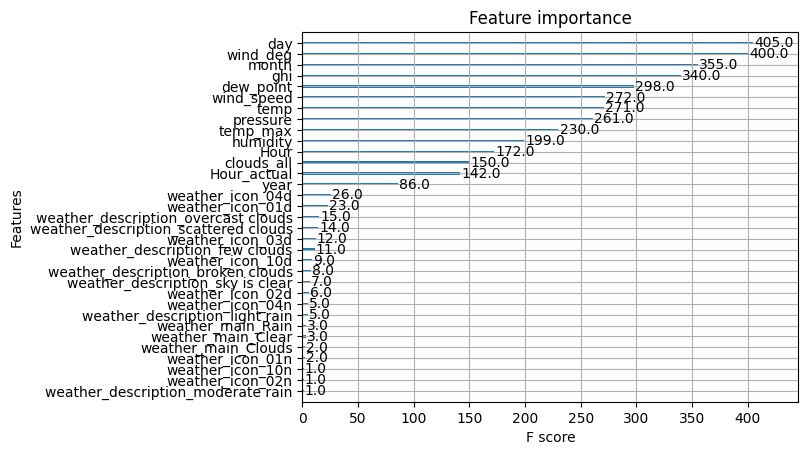

In [118]:
# Print feature importance
xgb.plot_importance(model)

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Generate the confusion matrix
y_pred = model.predict(X_test)
# Inverse transform the scaled predictions
#predictions = scaler.inverse_transform(predictions)
# Setting the prediction in a dataframe
#y_pred = pd.DataFrame(y_pred)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(y_pred)
print(score_mae)
print(score_rmse)

[ 0.04647176  0.01194776  0.00255809 ...  0.00234561  0.00837748
 -0.00081857]
0.0496061712821315
0.085686813384554


In [120]:
import plotly.graph_objects as go


# Create traces for X_train and y_train
trace_train = go.Scatter(x=list(range(len(X_train))), y=y_train, name='Train')

# Create traces for y_pred and y_test
trace_pred = go.Scatter(x=list(range(len(X_train), len(X_train) + len(y_pred))), y=y_pred, name='Predictions')
trace_test = go.Scatter(x=list(range(len(X_train), len(X_train) + len(y_test))), y=y_test, name='Actual')

# Create the layout for the plot
layout = go.Layout(title='Model Predictions vs Actual',
                   xaxis=dict(title='Index'),
                   yaxis=dict(title='Value'))

# Combine the traces and layout into a figure
fig = go.Figure(data=[trace_train, trace_test, trace_pred], layout=layout)

# Show the figure
fig.show()


In [121]:
import plotly.graph_objects as go

# Create traces for y_pred and y_test
trace_pred = go.Scatter(x=list(range(len(y_pred))), y=y_pred, name='Predictions')
trace_test = go.Scatter(x=list(range(len(y_test))), y=y_test, name='Actual')

# Create the layout for the plot
layout = go.Layout(title='Model Predictions vs Actual',
                   xaxis=dict(title='Index'),
                   yaxis=dict(title='Value'))

# Combine the traces and layout into a figure
fig = go.Figure(data=[trace_pred, trace_test], layout=layout)

# Show the figure
fig.show()


In [122]:
fig = px.scatter(x=y_test, y=y_pred)
fig.show()

In [123]:
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
df_train_scaled_target = scaler.fit_transform(final_df[['Actual']])

# Reshape y_pred to match the expected input shape
y_pred = y_pred.reshape(-1, 1)

# Inverse transform the predictions
predictions = scaler.inverse_transform(y_pred)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0 : "Actual"}, inplace=True)

In [124]:
# Reshape y_pred to match the expected input shape
y_test = pd.array(y_test)
y_test = y_test.reshape(-1, 1)

# Inverse transform the predictions
actuals = scaler.inverse_transform(y_test)
actuals = pd.DataFrame(actuals)
actuals.rename(columns={0 : "Actual_True"}, inplace=True)

In [125]:
actuals[actuals<0] = 0
actuals

Actual_True
0           768.0
1             0.0
2             0.0
3             0.0
4             0.0
...           ...
2925        874.0
2926          0.0
2927          3.0
2928          7.0
2929          6.0

[2930 rows x 1 columns]

In [126]:
predictions[predictions<0] = 0
predictions

Actual
0     732.023071
1     188.201050
2      40.295048
3      64.010597
4      12.911023
...          ...
2925  749.914551
2926   29.317753
2927   36.948044
2928  131.962128
2929    0.000000

[2930 rows x 1 columns]

In [127]:
fig = px.scatter(x=actuals['Actual_True'], y=predictions['Actual'])
fig.show()

In [128]:
y_pred = pd.DataFrame(y_pred[-168:])
y_pred.rename(columns={0 : "Predictions (LW)"}, inplace=True)
y_pred

Predictions (LW)
0            0.003073
1            0.003073
2            0.002309
3            0.001513
4            0.001513
..                ...
163          0.047608
164          0.001861
165          0.002346
166          0.008377
167         -0.000819

[168 rows x 1 columns]

In [129]:
y_test = pd.DataFrame(y_test[-168:])
y_test.rename(columns={0 : "Actual (LW)"}, inplace=True)
y_test

Actual (LW)
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
..           ...
163     0.055485
164     0.000000
165     0.000190
166     0.000444
167     0.000381

[168 rows x 1 columns]

In [130]:
fig = px.scatter(x=y_pred['Predictions (LW)'], y=y_test['Actual (LW)'])
fig.show()

# Linear Regression using only GHI (reference model)

In [131]:
scale = MinMaxScaler()

# selecting main features
data = data_full[['ghi','dni','clouds_all','Hour_DST','Actual']].copy()

# remove na rows
data.dropna(inplace=True)

# exclude night time hours
data = data.loc[(data['Hour_DST']>5)&(data['Hour_DST']<22)]

# setting the target
y = data['Actual'].copy()

# feature scaling
scaledX = scale.fit_transform(data.drop(['dni','clouds_all','Hour_DST','Actual'], axis=1))

# limiting features only to GHI
scaledX = pd.DataFrame(scaledX, columns=['ghi'])

# cross validation
cv = KFold(n_splits = 5, random_state=42, shuffle=True)
lm = LinearRegression()
scores = cross_val_score(lm, scaledX.values, y, scoring='r2', cv=cv, n_jobs=-1)
print(scores)


[0.80103562 0.79841293 0.80086531 0.79945075 0.79031756]


RMSE:  2374.425468535573
r2:  0.7422309030668649


C:\Users\Hugo\AppData\Local\Temp\ipykernel_21464\725302734.py:21: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.



Text(0.5, 1.0, 'Error Distribution')

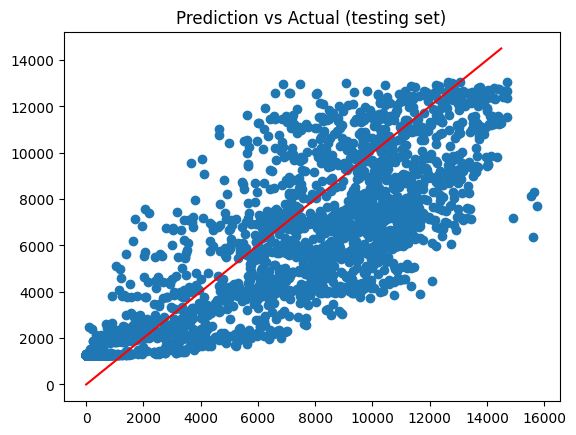

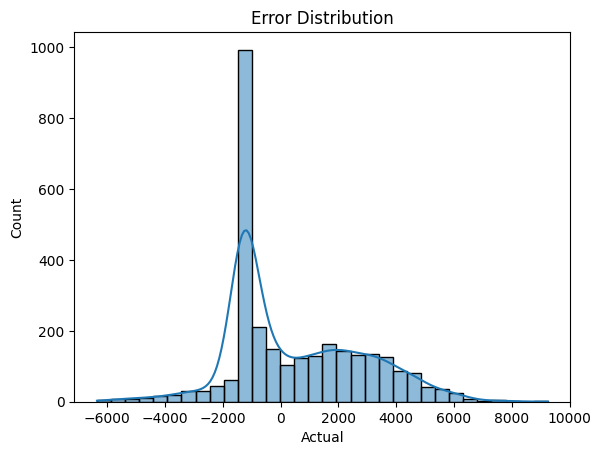

In [132]:
# train test split
#X_train, X_test, y_train, y_test = train_test_split(scaledX[['ghi']].values, y, test_size=0.2, random_state=42, shuffle=True)
X_train = scaledX.copy()[:-2930]
y_train = y.copy()[:-2930]
X_test = scaledX.copy()[-2930:]
y_test = y.copy()[-2930:]

# LR modeling
lm = LinearRegression()
lm.fit(X_train,y_train)
pred = lm.predict(X_test)

# error
RMSE = metrics.mean_squared_error(y_test,pred)**0.5
r2 = metrics.r2_score(y_test,pred)
print('RMSE: ', RMSE)
print('r2: ', r2)

# LR model fit quality
plt.scatter(y_test, pred)
plt.plot([0,14500],[0,14500],'k-', color = 'r')
plt.title('Prediction vs Actual (testing set)')

plt.figure()
sns.histplot(y_test-pred, kde=True)
plt.title("Error Distribution")

c:\Users\Hugo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



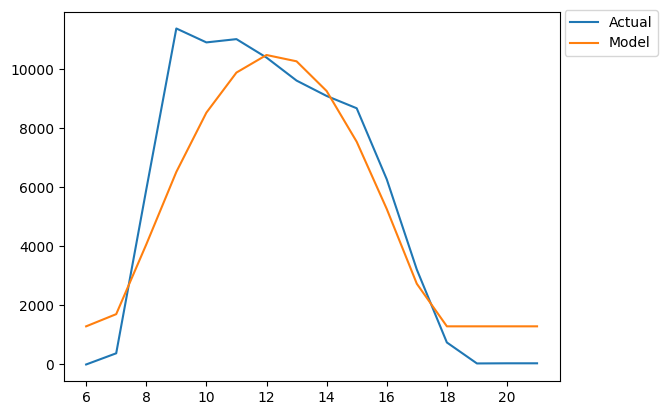

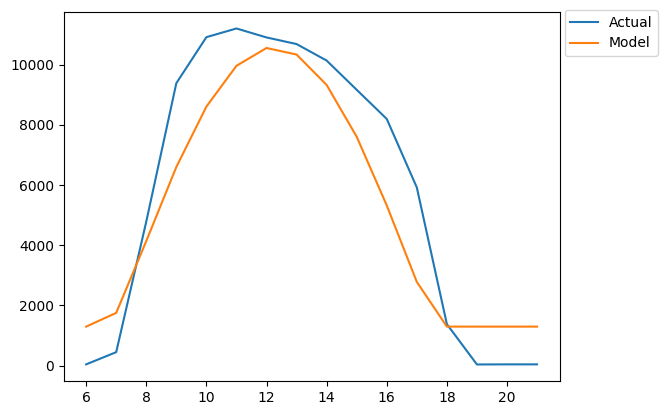

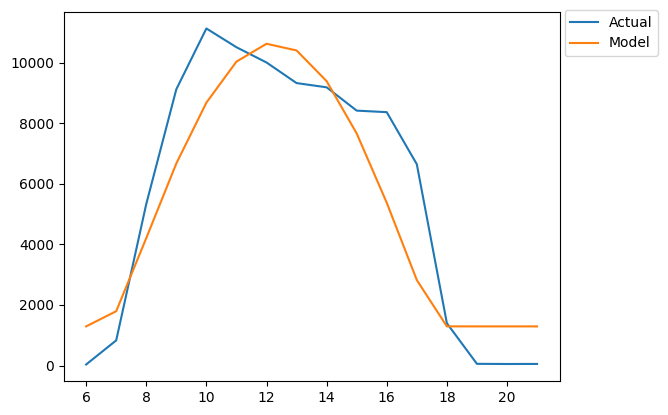

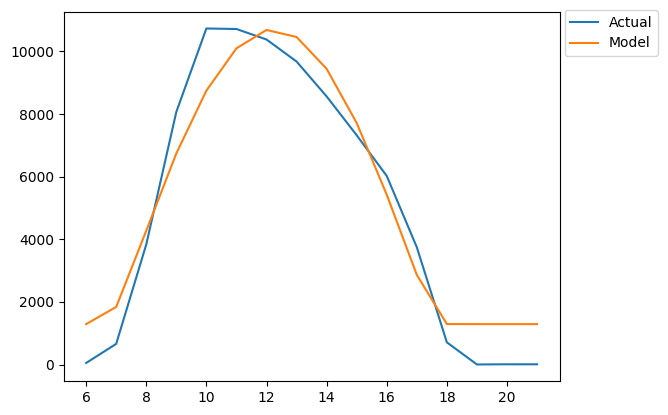

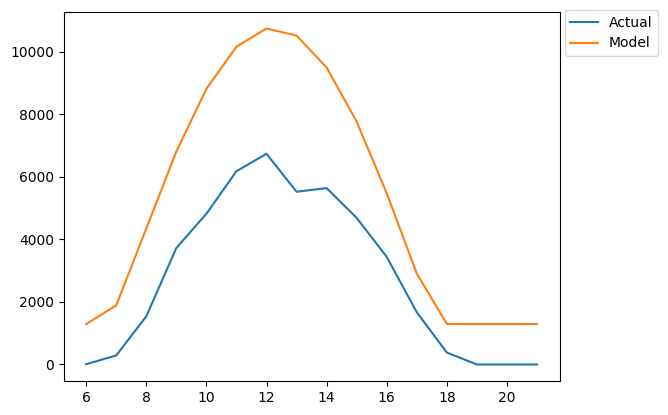

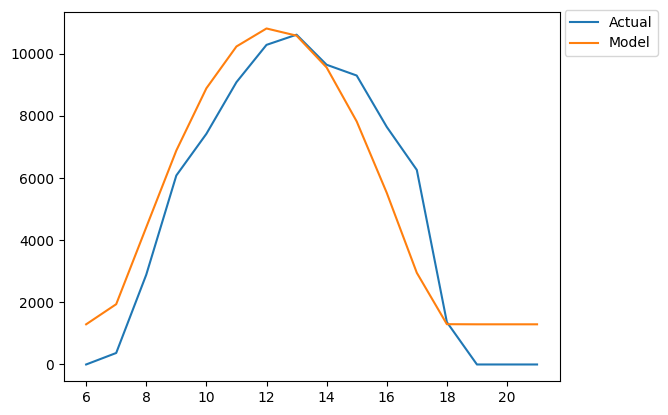

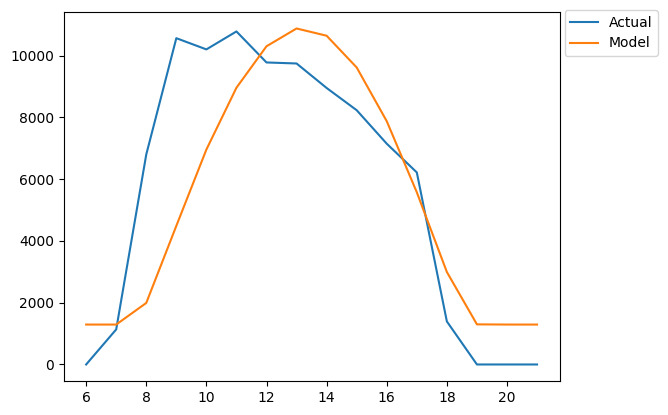

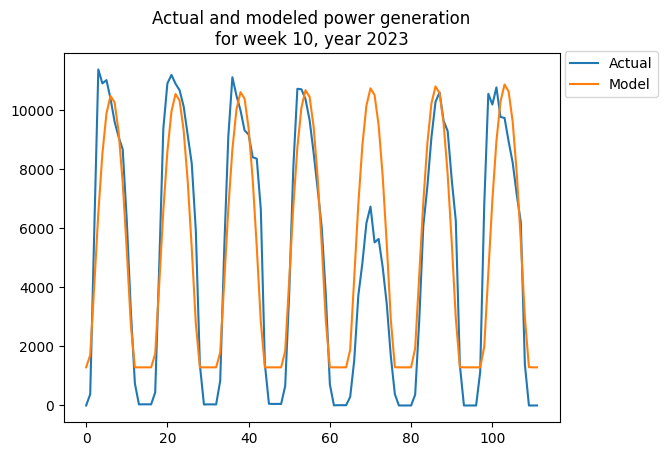

In [133]:
# plotting actual and predicted power generation vs time for one week (week 20, year 2022)

plt.figure()
Actual_model = lm.predict(scaledX[['ghi']].values)

# forcing negative values to 0
Actual_model[Actual_model<0]=0

data_full_ = data_full.copy()
data_full_ = data_full.loc[(data_full['Hour_DST']>5)&(data['Hour_DST']<22)].copy()
data_full_.reset_index(inplace=True)

for e in [2023]:
    data_y_ = data_full_[data_full_['year']==e].copy()
    
        
    for i in [10]:
        data_w_ = data_y_[data_y_['week']==i].copy()
        
#         plt.figure()
        for j in data_w_['day'].unique():
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'])
            
            
            index = data_w_[data_w_['day']==j].index
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index)])
            plt.legend(['Actual', 'Model'], loc=(1.01,0.88))
#             index = data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'].index
#             plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index[1])])
            plt.figure()
            
plt.plot(range(112),data_w_['Actual'])
index = data_w_.index
plt.plot(range(112),Actual_model[list(index)])
plt.title("Actual and modeled power generation\nfor week 10, year 2023")
plt.legend(['Actual', 'Model'], loc=(1.01,0.88))

# Linear Regression Excluding 0 production hours & categorical variables


In [134]:
scale = MinMaxScaler()


# selecting only critical variables that are well known to affect power generation
data = data_full[['ghi','dni','clouds_all','Hour_DST','Actual']].copy()

#forcing negative values to 0
data.loc[data['Actual']<=0, 'Actual']=0

# removing na rows
data.dropna(inplace=True)

# limiting the data to hours with power generation
data = data.loc[(data['Hour_DST']>5)&(data['Hour_DST']<22)]
y = data['Actual'].copy()

# features scaling
# scaledX = scale.fit_transform(data.drop(['dni','clouds_all','Hour_DST','Actual'], axis=1))
# scaledX = pd.DataFrame(scaledX[0:], columns=['ghi'])

# features scaling
scaledX = scale.fit_transform(data.drop(['dew_point','clouds_all','Hour_DST','Actual'], axis=1))
scaledX = pd.DataFrame(scaledX[0:], columns=['ghi','dni'])

# features scaling
# scaledX = scale.fit_transform(data.drop(['Actual'], axis=1))
# scaledX = pd.DataFrame(scaledX[0:], columns=['ghi','dni','dew_point','clouds_all','Hour_DST'])

# cross validation
cv = KFold(n_splits = 5, random_state=42, shuffle=True)
lm = LinearRegression()
scores = cross_val_score(lm, scaledX.values, y, scoring='r2', cv=cv, n_jobs=-1)
print(scores)

KeyError: "['dew_point'] not found in axis"

In [ ]:
# train test split
#X_train, X_test, y_train, y_test = train_test_split(scaledX[['ghi','dni']].values, y, test_size=0.2, random_state=42, shuffle=True)
X_train = scaledX.copy()[:-2930]
y_train = y.copy()[:-2930]
X_test = scaledX.copy()[-2930:]
y_test = y.copy()[-2930:]

# MLR modeling
lm = LinearRegression()
lm.fit(X_train,y_train)
pred = lm.predict(X_test)

# error
RMSE = metrics.mean_squared_error(y_test,pred)**0.5
r2 = metrics.r2_score(y_test,pred)
print('RMSE: ', RMSE)
print('r2: ', r2)

# MLR model fit quality
plt.scatter(y_test, pred)
plt.plot([0,14500],[0,14500],'k-', color = 'r')
plt.title('Prediction vs Actual (testing set)')

plt.figure()
sns.histplot(y_test-pred, kde=True)
plt.title("Error Distribution")

In [ ]:
# plotting actual and predicted power generation vs time for one week (week 20, year 2022)

plt.figure()
Actual_model = lm.predict(scaledX[['ghi','dni']].values)

# forcing negative values to 0
Actual_model[Actual_model<0]=0

# limiting the data to hours with power generation
data_full_ = data_full.loc[(data_full['Hour_DST']>5)&(data['Hour_DST']<22)].copy()
data_full_.reset_index(inplace=True)

for e in [2023]:
    data_y_ = data_full_[data_full_['year']==e].copy()
    
        
    for i in [10]:
        data_w_ = data_y_[data_y_['week']==i].copy()
        
#         plt.figure()
        for j in data_w_['day'].unique():
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'])
            
            
            index = data_w_[data_w_['day']==j].index
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index)])
#             index = data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'].index
#             plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index[1])])
            plt.figure()


plt.plot(range(112),data_w_['Actual'])
index = data_w_.index
plt.plot(range(112),Actual_model[list(index)])
plt.title("Actual and modeled power generation\nfor week 10, year 2023")
plt.legend(['Actual', 'Model'], loc=(1.01,0.88))
            

# Random Forest Model

In [ ]:
scale = MinMaxScaler()

# selecting all numeric variables
data = data_full[['ghi','dni','dew_point','clouds_all','Hour_DST','Actual','week','humidity','pressure','temp','wind_speed']].copy()

#forcing negative values to 0
data.loc[data['Actual']<=0, 'Actual']=0

# removing na rows
data.dropna(inplace=True)

# limiting the data to hours with power generation
data = data.loc[(data['Hour_DST']>5)&(data['Hour_DST']<22)]
y = data['Actual'].copy()

# features scaling
scaledX = scale.fit_transform(data.drop('Actual', axis=1))
scaledX = pd.DataFrame(scaledX, columns=['ghi','dni','dew_point','clouds_all','Hour_DST','week','humidity','pressure','temp','wind_speed'])

# selecting important features
scaledX = scaledX[['ghi','dni','clouds_all','humidity','pressure','week','Hour_DST']]

In [ ]:
#optimal number of trees 
#several models were run and RMSE & R^2 values were recorded with number of trees

plt.plot([1,5,10,20,30,40,50],[1766,1369,1303,1269,1261,1250,1246])
plt.title('RMSE vs Number of trees')

plt.figure()
plt.plot(np.array([1,5,10,20,30,40,50]),np.array([0.849,0.919,0.918,0.922,0.923,0.924,0.925]))
plt.title('R^2 vs Number of trees')

In [ ]:
# train test split
#X_train, X_test, y_train, y_test = train_test_split(scaledX[['ghi','dni','clouds_all','humidity','pressure','week']].values, y, test_size=0.2, random_state=42, shuffle=True)
X_train = scaledX.copy()[:-2930]
y_train = y.copy()[:-2930]
X_test = scaledX.copy()[-2930:]
y_test = y.copy()[-2930:]

# random forest modeling
rf_model = RandomForestRegressor(n_estimators=5, random_state=42, min_samples_leaf=11)
rf_model.fit(X_train,y_train)
pred = rf_model.predict(X_test)

# error
RMSE = metrics.mean_squared_error(y_test,pred)**0.5
r2 = metrics.r2_score(y_test,pred)
print('RMSE: ', round(RMSE))
print('r2: ', round(r2,3))

# random forest model fit quality
plt.scatter(y_test, pred)
plt.plot([0,14500],[0,14500],'k-', color = 'r')
plt.title('Prediction vs Actual (testing set)')

plt.figure()
sns.histplot(y_test-pred, kde=True)
plt.title("Error Distribution")

In [ ]:
# plotting actual and predicted power generation vs time for one week (week 20, year 2022)

plt.figure()
Actual_model = rf_model.predict(scaledX[['ghi','dni','clouds_all','humidity','pressure','week','Hour_DST']].values)

# forcing negative values to 0
Actual_model[Actual_model<0]=0

# limiting the data to hours with power generation
data_full_ = data_full.loc[(data_full['Hour_DST']>5)&(data['Hour_DST']<22)].copy()
data_full_.reset_index(inplace=True)

for e in [2022]:
    data_y_ = data_full_[data_full_['year']==e].copy()
    
        
    for i in [1]:
        data_w_ = data_y_[data_y_['week']==i].copy()
        
#         plt.figure()
        for j in data_w_['day'].unique():
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'])
            
            
            index = data_w_[data_w_['day']==j].index
            plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index)])
            plt.legend(['Actual', 'Model'], loc=(1.01,0.88))
#             index = data_w_[data_w_['day']==j]['Hour_DST'],data_w_[data_w_['day']==j]['Actual'].index
#             plt.plot(data_w_[data_w_['day']==j]['Hour_DST'],Actual_model[list(index[1])])
            plt.figure()

plt.plot(range(112),data_w_['Actual'])
index = data_w_.index
plt.plot(range(112),Actual_model[list(index)])
plt.title("Actual and modeled power generation\nfor week 10, year 2023")
plt.legend(['Actual', 'Model'], loc=(1.01,0.88))

# Time Series Modeling

# ARIMA Model (not good results)

In [ ]:
#Explore order for ARIMA (copumutation extensive)
time_searies_model = auto_arima(data_full['Actual'], Trace=True, suppress_warnings=True)
print(time_searies_model.summary())

In [ ]:
#Train test split
i=31
train = data_full['Actual'][720*i:720*(i+1)].copy()
test = data_full['Actual'][720*(i+1)+1:720*(i+1)+73].copy()

#SARIMA model fit
time_searies_model = sm.tsa.statespace.SARIMAX(train, order=(1,1,2))
time_searies_model = time_searies_model.fit()
pred = time_searies_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
plt.plot(range(72),test)
plt.plot(range(72),pred)
plt.title("Actual and modeled power generation\n1 week ahead")
plt.legend(['Actual', 'Model'], loc=(1.01,0.88))

# Autoregressive Model

In [ ]:
#find the optimal number of lags (optimal is 74)
train = data_full['Actual'][:-71].copy()
test = data_full['Actual'][-71:].copy()
plot_pacf(train, lags=72)

In [ ]:
#error calculation 
RMSE=[]
r2=[]
test_list =[]
pred_list=[]

for i in range(36):
    
    #train-test split
    train = data_full['Actual'][720*i:720*(i+1)].copy()
    test = data_full['Actual'][720*(i+1)+1:720*(i+1)+73].copy()
    test_list.append(test)
    

    #model fit
    time_searies_model = AutoReg(train, lags=50).fit()

    #1-week forecast
    pred = time_searies_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    pred[pred<0]=0
    pred_list.append(pred)
    
    
#    plt.scatter(test[:71], pred[1:72])
#    plt.scatter(test, pred)
#    plt.plot([0,14500],[0,14500],'k-', color = 'r')
#    plt.title('Prediction vs Actual (testing set)')
#    plt.figure()
#    plt.plot(range(71),test[:71])
#    plt.plot(range(71),pred[1:72])
#    plt.plot(range(72),test)
#    plt.plot(range(72),pred)
#    plt.title('Actual & forecast output')
#    plt.legend(['Actual', 'Model'], loc=(1.01,0.88))
#    plt.figure()
    
    #RMSE 

    er = metrics.mean_squared_error(test.reset_index(drop=True)[:71], pred.reset_index(drop=True)[1:72])**0.5
    r2_ = metrics.r2_score(test.reset_index(drop=True)[:71], pred.reset_index(drop=True)[1:72])
#     er = metrics.mean_squared_error(test.reset_index(drop=True), pred.reset_index(drop=True))**0.5
#     r2_ = metrics.r2_score(test.reset_index(drop=True), pred.reset_index(drop=True))
    
#     RMSE.append(er.mean())
    RMSE.append(er)
    r2.append(r2_)

test_list =np.concatenate(test_list)
pred_list=np.concatenate(pred_list)
    
plt.scatter(test_list, pred_list)
plt.plot([0,14500],[0,14500],'k-', color = 'r')
plt.title('Prediction vs Actual (testing set)')
plt.figure()
sns.histplot(test_list- pred_list, kde=True)
plt.title("Error Distribution")
plt.figure()
plt.plot(RMSE)


print(sum(RMSE)/len(RMSE))
print(sum(r2)/len(r2))

In [ ]:
rank_table = {'Model':['Linear Regression (GHI)', 'Linear Regression (GHI, DNI)', 'Random Forest', 'Two Random Forests', 'ARIMA', 'Autoregressive', 'Shifted Autoregressive','XGBoost'],
         'RMSE':[2379, 1897, 1666, 2492, 'NA', 1900, 1055,0], 
         'R2':[0.741, 0.836, 0.873, 0.716, 'NA', 0.761, 0.895,0],
        'Rank':[0,0,0,0,0,0,0,0]}

rank_table = pd.DataFrame(rank_table)
rank_table